# 0. Imports

In [2]:
from pathlib import Path
from typing import *
import numpy as np
import scipy
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import mdsine2 as md2
from mdsine2.names import STRNAMES

from tqdm.notebook import tqdm
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import seaborn as sb
import pickle
import sys
sys.path += [str(Path().resolve().parent / 'submodules' / 'clv_fork')]
sys.path += [str(Path().resolve().parent / "scripts" / "semisynthetic2" / "data_generation" / "python_helpers")]
from generalized_lotka_volterra import GeneralizedLotkaVolterra
from lv_forward_sims import forward_sim_single_subj_glv
import statsmodels
import statsmodels.stats
import statsmodels.stats.multitest

# import sys
# sys.path = ['/data/local/MDSINE2_Paper/paper_figures', 'submodules/clv_fork', '/home/youn/mambaforge/envs/mdsine2/lib/python37.zip', '/home/youn/mambaforge/envs/mdsine2/lib/python3.7', '/home/youn/mambaforge/envs/mdsine2/lib/python3.7/lib-dynload', '', '/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages', '/home/youn/work/MDSINE2', '/home/youn/mambaforge/envs/mdsine2/lib/python3.7/site-packages/IPython/extensions', '/home/youn/.ipython']
# from generalized_lotka_volterra import GeneralizedLotkaVolterra

[DEBUG] Using default logger (stdout, stderr).


In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [52]:
GLV_TRUTH_SIM_DIR = Path("/data/cctm/youn/MDSINE2_Paper/datasets/semisynthetic2/truth")
BASE_STUDY_PATH = Path("/data/local/MDSINE2_Paper/datasets/gibson/healthy/preprocessed/gibson_healthy_agg_filtered.pkl")  # for extracting perturbation names and taxaset
SEMISYN_ANALYSIS_DIR = Path("/data/cctm/youn/MDSINE2_semisynthetic2/output")

# 1. Ground Truth

In [4]:
from collections import namedtuple
GLVParamSet = namedtuple(
    'GLVParamSet',
    [
        'growth', 'interactions', 'perturbations'
    ]
)

def load_ground_truth():
    with open(GLV_TRUTH_SIM_DIR / "glv_best_sim.pkl"), "rb") as f:
        glv = pickle.load(f)
    coclust = np.load(GLV_TRUTH_SIM_DIR / "coclusters.npy")
    return glv, coclust


truth_glv, truth_coclust = load_ground_truth()

base_study = md2.Study.load(str(BASE_STUDY_PATH))
base_taxa = base_study.taxa

# 2. Helper Code

## Helper code: 

- Matrix/Array index synchronization
- Off-diagonal matrix indexing

In [5]:
def off_diagonal_entries(A: np.ndarray):
    r_tril, c_tril = np.tril_indices(n=A.shape[0], m=A.shape[1], k=-1)
    r_triu, c_triu = np.triu_indices(n=A.shape[0], m=A.shape[1], k=1)
    off_diag_r = np.concatenate([r_triu, r_tril])
    off_diag_c = np.concatenate([c_triu, c_tril])
    return A[off_diag_r, off_diag_c]


def synchronize_array_to_taxa(arr: np.ndarray, full_taxa, taxa_name_subset: List[str]) -> np.ndarray:
    """
    Assuming arr is indexed by full_taxa, re-order the indexing according to the ordering given by taxa_name_subset.
    If taxa_name_subset is a subset of full_taxa, then this takes the subset slice with the proper ordering.
    If there's a taxa in taxa_name_subset that's not present in full_taxa, then it fills the value with zeroes.
    """
    assert arr.shape[-1] == len(full_taxa)
    
    indices_to_keep = [full_taxa[t_name].idx for t_name in taxa_name_subset if t_name in full_taxa]
    indices_found = [i for i, t_name in enumerate(taxa_name_subset) if t_name in full_taxa]
    # indices_missing = [i for i, t_name in enumerate(taxa_name_subset) if t_name not in full_taxa]

    if arr.ndim == 1:
        subset_view = np.zeros(len(taxa_name_subset), dtype=arr.dtype)
        subset_view[indices_found] = arr[indices_to_keep]
        return subset_view
    elif arr.ndim == 2:
        subset_view = np.zeros((arr.shape[0], len(taxa_name_subset)), dtype=arr.dtype)
        subset_view[:, indices_found] = arr[:, indices_to_keep]
        return subset_view
    else:
        raise ValueError("Arg `arr` had ndim={}".format(arr.ndim))


def synchronize_matrix_to_taxa(matrix: np.ndarray, full_taxa, taxa_name_subset: List[str], fill_value: float = 0.0) -> np.ndarray:
    assert matrix.shape[-1] == len(full_taxa)
    assert matrix.shape[-2] == len(full_taxa)
    indices_to_keep = [full_taxa[t_name].idx for t_name in taxa_name_subset if t_name in full_taxa]
    indices_found = [i for i, t_name in enumerate(taxa_name_subset) if t_name in full_taxa]
    # indices_missing = [i for i, t_name in enumerate(taxa_name_subset) if t_name not in full_taxa]

    N = len(taxa_name_subset)
    if matrix.ndim == 2:
        subset_view = np.full((N, N), fill_value=fill_value, dtype=matrix.dtype)
        subset_view[np.ix_(indices_found, indices_found)] = matrix[indices_to_keep, :][:, indices_to_keep]
        return subset_view
    elif matrix.ndim == 3:
        n_samples = matrix.shape[0]
        subset_view = np.full((n_samples, N, N), fill_value=fill_value, dtype=matrix.dtype)
        subset_view[np.ix_(
            range(n_samples), indices_found, indices_found
        )] = matrix[:, indices_to_keep, :][:, :, indices_to_keep]
        return subset_view
        # matrix = matrix[:, indices_to_keep, :]
        # matrix = matrix[:, :, indices_to_keep]
        # return matrix
    else:
        raise ValueError("Arg `matrix` had ndim={}".format(matrix.ndim))


def synchronize_fwsims_to_taxa(fwsims: np.ndarray, full_taxa, taxa_name_subset: List[str]) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    assert fwsims.shape[-2] == len(full_taxa)
    indices_to_keep = [full_taxa[t_name].idx for t_name in taxa_name_subset if t_name in full_taxa]
    indices_found = [i for i, t_name in enumerate(taxa_name_subset) if t_name in full_taxa]

    N = len(taxa_name_subset)
    if fwsims.ndim == 2:
        # expect a (n_taxa x n_timepoints) tensor.
        subset_view = np.zeros((N, fwsims.shape[1]), dtype=fwsims.dtype)
        subset_view[indices_found, :] = fwsims[indices_to_keep, :]
        return subset_view
    elif fwsims.ndim == 3:
        # expect a (n_samples x n_taxa x n_timepoints) tensor.
        subset_view = np.zeros((fwsims.shape[0], N, fwsims.shape[2]), dtype=fwsims.dtype)
        subset_view[:, indices_found, :] = fwsims[:, indices_to_keep, :]
        return subset_view
    else:
        raise ValueError("Arg `fwsims` had ndim={}".format(fwsims.ndim))


def off_diagonal_entries(A: np.ndarray):
    r_tril, c_tril = np.tril_indices(n=A.shape[0], m=A.shape[1], k=-1)
    r_triu, c_triu = np.triu_indices(n=A.shape[0], m=A.shape[1], k=1)
    off_diag_r = np.concatenate([r_triu, r_tril])
    off_diag_c = np.concatenate([c_triu, c_tril])
    return A[off_diag_r, off_diag_c]

## Helper code: MCMC Pickle extraction

In [6]:
def extract_interactions(_mcmc: md2.BaseMCMC):
    interactions = _mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk(section='posterior')

    self_interactions = _mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk(section='posterior')
    self_interactions = -np.absolute(self_interactions)

    for i in range(self_interactions.shape[1]):
        interactions[:, i, i] = self_interactions[:, i]
    return interactions


def extract_growths(_mcmc: md2.BaseMCMC):
    return _mcmc.graph[STRNAMES.GROWTH_VALUE].get_trace_from_disk(section='posterior')


def extract_coclusterings(_mcmc: md2.BaseMCMC):
    clustering = _mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    return clustering.coclusters.get_trace_from_disk(section="posterior")


def extract_perts(mcmc: md2.BaseMCMC, pert_name: str) -> np.ndarray:
    if pert_name not in mcmc.graph.perturbations:
        raise KeyError("Pert name `{}` is not one of {}.".format(
            pert_name,
            list(mcmc.graph.perturbations.keys())
        ))
    perts = mcmc.graph.perturbations[pert_name].get_trace_from_disk(section='posterior')
    return perts


def synchronize_clustering_to_taxa(clustering_assignments: np.ndarray, full_taxa, subset_taxa_names) -> np.ndarray:
    subset_taxa_names = set(subset_taxa_names)
    indices_to_keep = [t_idx for t_idx, t in enumerate(full_taxa) if t.name in subset_taxa_names]
    clustering_assignments = np.copy(clustering_assignments[indices_to_keep])
    
    # fix cluster indexing, just in case.
    leftover_clusters = np.unique(clustering_assignments)
    cluster_mapping = {c: i for i, c in enumerate(leftover_clusters)}
    for i in range(len(clustering_assignments)):
        clustering_assignments[i] = cluster_mapping[clustering_assignments[i]]
    return clustering_assignments


def extract_clustering_from_matrix(_mat):
    n_items = _mat.shape[0]
    items_left = set(range(n_items))

    clustering_assignments = np.zeros(n_items, dtype=int)

    c_idx = -1
    while len(items_left) > 0:
        c_idx += 1  # new cluster
        x = items_left.pop()  # member
        clustering_assignments[x] = c_idx

        # get all guys in the same cluster
        to_remove = set()
        for y in items_left:
            if _mat[x,y]:
                clustering_assignments[y] = c_idx
                to_remove.add(y)
        items_left = items_left.difference(to_remove)
    return clustering_assignments


def extract_n_clusters(_mcmc: md2.BaseMCMC):
    clustering = _mcmc.graph[STRNAMES.CLUSTERING_OBJ]
    return clustering.n_clusters.get_trace_from_disk(section='posterior')

## Helper code: Data Loading

In [7]:
class MCMCError(BaseException):
    pass


def regression_output(result_dir: Path, model_name: str, regression_type: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parser for the clv/linear regression outputs.
    """
    input_dir = result_dir / "inputs"
    output_dir = result_dir / model_name / regression_type
    if not (output_dir / "regression.DONE").exists():
        raise FileNotFoundError(f"Regression for {model_name}, {regression_type} in {result_dir} not yet done.")
    
    result_paths = list(output_dir.glob('*.pkl'))
    if len(result_paths) == 0:
        raise FileNotFoundError(f"Unable to locate any .pkl files in {result_dir}.")
    if len(result_paths) > 1:
        print(f"[WARNING] the directory {result_dir} contains {len(result_paths)} pickle files.")
    result_path = result_paths[0]

    with open(result_path, 'rb') as f:
        res = pickle.load(f)
    est_interactions = res.A
    est_growth = res.g
    est_perts = res.B
    return est_growth, est_interactions, est_perts


class SemisyntheticSuite():
    def __init__(self, output_base_dir: Path):
        self.output_base_dir = output_base_dir

    """
    formats
    mdsine2: /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_9/perts_3/data_repl_2/mice_2/timepoints_all/mdsine2/synthetic/
    regression: /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_9/perts_3/data_repl_2/mice_2/timepoints_all/regression/glv/elastic_net/
    """
    def instance_subdir(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> Path:
        return self.output_base_dir / f"traj_repl_{traj_repl}" / f"perts_{perts}" / f"data_repl_{data_repl}" / f"mice_{n_mice}" / f"timepoints_{timeseries_id}"

    def get_instance_taxa(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> md2.TaxaSet:
        taxa = md2.Study.load(self.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / "mdsine2" / "synthetic_filtered.pkl").taxa
        return taxa

    def get_mdsine2_generic(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, method_name: str, output_name: str) -> md2.BaseMCMC:
        # Try to load the MCMC chain.
        run_key = f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id}|{method_name}|{output_name}"
        mcmc_path = self.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / method_name / output_name / "mcmc.pkl"
        # study = md2.Study.load(mcmc_path.parent / "subjset.pkl")
        if not mcmc_path.exists():
            raise FileNotFoundError(f"Inference for {run_key} doesn't seem to be done.")
        
        mcmc = md2.BaseMCMC.load(mcmc_path)
        # taxa = study.taxa
        growths = extract_growths(mcmc)
        n_samples = growths.shape[0]
        
        if n_samples != 10000:
            raise MCMCError(f"[WARNING] mcmc pickle from {run_key} only contains {n_samples} samples.")
        return mcmc

    def get_mdsine2(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> md2.BaseMCMC:
        return self.get_mdsine2_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, "mdsine2", "synthetic")

    def get_mdsine2_nomodule(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> md2.BaseMCMC:
        return self.get_mdsine2_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, "mdsine2", "synthetic_nomodule")

    def get_mdsine2_ra(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> md2.BaseMCMC:
        return self.get_mdsine2_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, "mdsine2_ra", "synthetic")

    def get_mdsine2_ra_nomodule(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str) -> md2.BaseMCMC:
        return self.get_mdsine2_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, "mdsine2_ra", "synthetic_nomodule")
        
    def get_regression(self, traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, model: str, opt: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, md2.TaxaSet]:
        regression_result_dir = self.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / "regression"
        r, A, perts_additive = regression_output(regression_result_dir, model, opt)

        n_taxa = r.shape[0]
        # assert len(taxa) == r.shape[0]
        try:
            assert n_taxa == A.shape[0]
            assert n_taxa == A.shape[1]
        except AssertionError:
            print("Assertion failed. Expected ({}, {}) matrix but got {}.".format(
                n_taxa, n_taxa, A.shape
            ))
            print(A)
            raise
        return r, A, perts_additive

## (Invoke the above helper.)

In [8]:
semisynthetic_outputs = SemisyntheticSuite(output_base_dir=SEMISYN_ANALYSIS_DIR)

## Helper code: Plotting

In [9]:
# PLOTTING HELPERS
def annotate_pvalues(
    ax, 
    x_col: str,
    pvalue_df: pd.DataFrame, 
    err_df: pd.DataFrame, 
    column_name: str,
    method_order: List[str], 
    y_offset_factor: float = 0.2, 
    dy: float = None,
    overlap_gap: float = 0.1,
    show_nonsig: bool = True,
    show_sig: bool = True,
    cascade_above: bool = True,
    debug=False
):
    """
    Annotate non-significant pairs with a marker.
    :param offset_factor: controls the space between the bracket and the maximal datapoint (if cascade_above is True, otherwise computes the min)
    :param dy: the height of the bracket.
    :param overlap_gap: controls the height difference between overlapping brackets.
    :param cascade_above: (default = True) if True, significance brackets cascade UPWARDS (so y-value is incremented) to avoid overlaps. if False, cascades DOWNWARDS instead.
    """
    method_indices = {m: i for i, m in enumerate(method_order)}
    x_indices = {r: i for i, r in enumerate(pd.unique(err_df[x_col]))}
    # subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] < np.max(sig_levels), :]
    if dy is None:
        dy = err_df[column_name].max() * 0.03
    overlap_offsets = {r: 0 for r in x_indices.keys()}

    # these are the seaborn x-coordinates per category (not counting offset)
    _spread = np.arange(0, len(method_order), dtype=float)
    _spread = 0.8 * (_spread / len(_spread))
    _spread = _spread - np.mean(_spread)
    def _get_method_xpos(method_name: str, x_val: int) -> float:
        ri = x_indices[x_val]
        mi = method_indices[method_name]
        return ri + _spread[mi]

    pvalue_df = pvalue_df.sort_values("Method")
    y_min, y_max = err_df[column_name].min(), err_df[column_name].max()
    for base_method, base_method_section in pvalue_df.groupby("Method"):
        for _, row in pvalue_df.iterrows():
            pval = row[f'Pval_{column_name}']

            if pval > 0.05:
                if not show_nonsig:
                    continue
                else:
                    marker_str = "n.s."
            else:
                if not show_sig:
                    continue
                elif pval > 0.01:
                    marker_str = "*"
                elif pval > 0.001:
                    marker_str = "**"
                else:
                    marker_str = "***"
                    
            x_val = row[x_col]
            comparator = row['Comparator']
            x1 = _get_method_xpos(base_method, x_val)
            x2 = _get_method_xpos(comparator, x_val)
            if cascade_above:
                y1 = err_df.loc[
                    (err_df[x_col] == x_val) & (err_df['Method'].isin(method_order)),
                    column_name
                ].max() * (1 + y_offset_factor) + (overlap_offsets[x_val] * overlap_gap)
                # if debug:
                #     display(err_df.loc[
                #         (err_df[x_col] == x_val) & (err_df['Method'].isin(method_order)),
                #         column_name
                #     ])
                #     print(marker_str, ":", column_name, y1)
                
                y2 = y1 + dy
                y_max = max(y_max, y2)
            else:
                y1 = err_df.loc[
                    (err_df[x_col] == x_val),
                    column_name
                ].min() * (1 - y_offset_factor) - (overlap_offsets[x_val] * overlap_gap)
                y2 = y1 - dy
                y_min = min(y_min, y2)
            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], color='black', linewidth=1.0, linestyle='-')
           
            ax.text(x=0.5 * (x1+x2), y=y2, s=marker_str, ha='center', va='bottom', size=10.0)
            overlap_offsets[x_val] += 1
    return y_min, y_max


def get_pvalue_df(metrics_df, x_col, y_col, methods1, methods2, alt='two-sided', debug=False) -> pd.DataFrame:
    pvalue_entries = []
    print("Evaluating p-value for: x={}, y={}".format(x_col, y_col))
    for x_value, x_section in metrics_df.groupby(x_col):
        for method1, method2 in itertools.product(methods1, methods2):
            entry = {
                x_col: x_value,
                'Method': method1,
                'Comparator': method2
            }
    
            m1 = x_section.loc[x_section['Method'] == method1, :].sort_values(["TrajReplicate", "NumPerts", "DataReplicate", "NumMice"])
            m2 = x_section.loc[x_section['Method'] == method2, :].sort_values(["TrajReplicate", "NumPerts", "DataReplicate", "NumMice"])
            if m1.shape[0] == 0:
                print("Section not available for method `{}` @ {}={}.".format(method1, x_col, x_value))
                continue
            if m2.shape[0] == 0:
                print("Section not available for method `{}` @ {}={}.".format(method2, x_col, x_value))
                continue

            _merged = m1[["TrajReplicate", "NumPerts", "DataReplicate", "NumMice", y_col]].merge(
                m2[["TrajReplicate", "NumPerts", "DataReplicate", "NumMice", y_col]],
                on=["TrajReplicate", "NumPerts", "DataReplicate", "NumMice"],
                suffixes=['_1', '_2'],
                how='outer',
            )
            # if debug:
            #     print("Method1 = {}, Method2 = {}".format(method1, method2))
            #     display(_merged)
            a = _merged[f'{y_col}_1'].to_numpy()
            b = _merged[f'{y_col}_2'].to_numpy()
            
            valid_indices, = np.where(~np.isnan(b) & ~np.isnan(a))
            a = a[valid_indices]
            b = b[valid_indices]
            if a.shape[0] == 0:
                print("Only NaNs for method pair `{}+{}` @ {}={}".format(method1, method2, x_col, x_value))
                continue

            if len(a) > len(b):
                b = np.concatenate([b, b[-1] * np.ones(len(a) - len(b))])

            statistic, pvalue = scipy.stats.wilcoxon(a, b, alternative=alt)
            entry[f'Pval_{y_col}'] = pvalue
            entry[f'Statistic_{y_col}'] = statistic
            pvalue_entries.append(entry)
    pvalues = pd.DataFrame(pvalue_entries)
    
    for col in pvalues.columns:
        if col.startswith('Pval'):
            nan_locs = pvalues[col].isna()

            # only evaluate using non-nan values.
            rej, pval_bh = statsmodels.stats.multitest.fdrcorrection(pvalues.loc[~nan_locs, col].to_numpy(), alpha=0.05, method='p') ## alpha doesn't matter here, we want to output raw p-values with multiple-hypothesis correction
            pvalues.loc[~nan_locs, f'{col}_Raw'] = pvalues[col]
            pvalues.loc[~nan_locs, col] = pval_bh
    return pvalues


def box_and_scatter_plot(
    df, ax, x, y, method_order, method_colors, title=None, render_pvalues=True, show_nonsig=True, show_sig=True,
    baseline_method='MDSINE2',
    x_order=None,
    pvalue_offset_factor=0.2,
    pvalue_dy=None,
    pvalue_overlap_gap=0.1,
    show_points=True,
    show_grid=True,
    debug_pvals=False
):
    if df.shape[0] == 0:
        raise RuntimeError("Dataframe is empty, nothing to plot.")
    df = df.reset_index()
    ax.set_axisbelow(True)
    sb.boxplot(
        df,
        x=x, y=y, hue='Method', order=x_order,
        palette=method_colors, hue_order=method_order,
        showfliers=False,
        ax=ax, zorder=1,
        boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
        medianprops=dict(color='black', linewidth=1),           # Median line
        whiskerprops=dict(color='black', linewidth=1),  # Whiskers
        capprops=dict(color='black', linewidth=1)            # Caps
    )
    ax.legend().remove()
    if show_points:
        sb.stripplot(
            df,
            x=x, y=y, 
            hue='Method', order=x_order,
            palette=method_colors, hue_order=method_order,
            ax=ax, ec='black', linewidth=1.0, 
            dodge=True,
            legend=False, alpha=0.7, zorder=2
        )
    if title is not None:
        ax.set_title(title)
    ax.grid(True, which='major', axis='y', zorder=0)

    # annotate p-values
    if render_pvalues:
        remaining_methods = set(method_order)
        remaining_methods.remove(baseline_method)
    
        pvalue_df = get_pvalue_df(df, x, y, [baseline_method], sorted(remaining_methods), debug=debug_pvals)
        # display(pvalue_df)
        y_min, y_max = annotate_pvalues(
            ax, 
            x,
            pvalue_df,
            df,
            column_name=y,
            method_order=method_order, 
            y_offset_factor=pvalue_offset_factor, 
            dy=pvalue_dy,
            overlap_gap=pvalue_overlap_gap,
            cascade_above=True,
            show_nonsig=show_nonsig, show_sig=show_sig, debug=debug_pvals
        )
        return pvalue_df

## Helper code: Taxa Set Union/Intersection

In [10]:
def get_taxa_collection(param_collection: List[Tuple[int, int, int, int, str]], strategy: str = 'union') -> List[str]:
    if strategy.lower() == 'union':
        if len(param_collection) > 1:
            print("using the UNION strategy.")
        return get_taxa_collection_union(param_collection)
    elif strategy.lower() == 'intersection':
        if len(param_collection) > 1:
            print("using the INTERSECTION strategy.")
        return get_taxa_collection_intersection(param_collection)
    else:
        raise Exception("Unknown taxa merging strategy {}".format(strategy))

def get_taxa_collection_union(param_collection: List[Tuple[int, int, int, int, str]]) -> List[str]:
    taxa_name_intersection = set()
    for traj_repl, perts, data_repl, n_mice, timeseries_id in param_collection:
        try:
            run_key = f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id}"
            instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
            taxa_name_intersection = taxa_name_intersection.union(
                set(t.name for t in instance_taxa)
            )
        except FileNotFoundError as e:
            print(e)
            continue
        except MCMCError as e:
            print(e)
            continue
    return sorted(list(taxa_name_intersection))


def get_taxa_collection_intersection(param_collection: List[Tuple[int, int, int, int, str]]) -> List[str]:
    taxa_name_intersection = set(t.name for t in base_taxa)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in param_collection:
        try:
            run_key = f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id}"
            instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
            taxa_name_intersection = taxa_name_intersection.intersection(
                set(t.name for t in instance_taxa)
            )
        except FileNotFoundError as e:
            print(e)
            continue
        except MCMCError as e:
            print(e)
            continue
    return sorted(list(taxa_name_intersection))

## Helper code: Regression Evaluation

In [11]:
import numpy as np
from scipy.stats import t as t_dist


class Ridge():
    def __init__(self, X, T, r_A, r_B, r_g, U=None, scale=1):
        """
           ([np.array]) X : a list of T(total time) by N dimensional (log)abundance
                            matrix
           ([np.array]) U : a list of T(total time) by P dimensional perturbation
                            matrix; optional
           ([np.array]) T : a list of T by 1 dimensional number array containing
                            the timepoints at which measurements were taken
           (int) r_A : regularization parameter for interaction coefficients
           (int) r_B : regularization parameter for perturbation coefficients
           (int) r_g : regularization parameter for growth term
        """

        self.X = X
        self.U = U
        self.T = T
        self.r_A = r_A
        self.r_B = r_B
        self.r_g = r_g
        self.regularizers = self.make_regularizer_list()
        self.XU = []
        self.scale = scale

        #the interaction, perturbation, and growth parameters 
        self.A = None 
        self.B = None 
        self.g = None

        try:
            if self.U is not None:
                assert len(X) == len(U)
                for i in range(len(X)):
                    if U[i].shape[0] != X[i].shape[0]:
                        raise Exception("Error with dimensions.")
                    if np.sum([np.sum(u) for u in U]) != 0:
                        xu = np.hstack((np.exp(X[i]), np.ones((X[i].shape[0], 1)),
                            U[i]))
                        self.XU.append(xu[0:-1])
            else:
                for i in range(len(X)):
                    x = np.hstack((np.exp(X[i]), np.ones((X[i].shape[0], 1))))
                    self.XU.append(x[0:-1])

        except AssertionError:
            print("The dimensions of X and Y are not equal")

        self.Y = self.construct_Y()

    def construct_Y(self):
        """
            the left hand side of the gLV equation
        """

        Y = []
        for i in range(len(self.X)):
            X_i = self.X[i]
            shape = X_i.shape
            Y_arr = np.zeros((shape[0]-1, shape[1]))
            T_i = self.T[i]
            for t in range(1, shape[0]):
                del_t = T_i[t] - T_i[t-1]
                Y_arr[t-1] = (X_i[t] - X_i[t-1]) / del_t
            Y.append(Y_arr)

        return Y

    def make_regularizer_list(self):
        """
            combine the regularizers for different variables together
        """

        x_dim = self.X[0].shape[1]

        regularizers = []
        if self.U is None:
            regularizers = [self.r_A for i in range(x_dim)]+ [self.r_g]
        else:
            u_dim = self.U[0].shape[1]
            regularizers = [self.r_A for i in range(x_dim)] + [self.r_g] + \
                [self.r_B for i in range(u_dim)]

        return regularizers

    def solve(self):
        """
            solves the Ridge Regression problem and return the coefficients
        """

        x_dim = self.X[0].shape[1]
        Z_mat = np.vstack(self.XU)
        Y_mat = np.vstack(self.Y)
        diag_reg = np.diag(np.array(self.regularizers))

        ZZ = np.matmul(Z_mat.T, Z_mat)
        term1 = np.linalg.inv(ZZ + diag_reg)
        term2 = np.matmul(Z_mat.T, Y_mat)

        theta = np.matmul(term1, term2)
        A = theta[0:x_dim, :]
        g = theta[x_dim: x_dim + 1, :]
        B = None
        if self.U is not None:
            B = theta[x_dim+1:, :]

        self.A = A 
        self.B = B 
        self.g = g

        return A, g, B

    def map_t_to_p(self, t_values, deg_freedom):
        """
            generates p-values associated with the test statistics for Student-t
            distribution
        """

        dist = t_dist(deg_freedom)
        p_values = 2 * (1 - dist.cdf(np.abs(t_values)))

        return p_values


    def get_params(self):
        """return the interaction, growth and perturbation coefficients 
           computed by ridge regression
        """

        return self.A * self.scale, self.g, self.B


    def compute_hat_matrix(self):
        """
            computes the hat matrix used in computation of effective degrees
            of freedom
        """

        Z_mat = np.vstack(self.XU)
        Y_mat = np.vstack(self.Y)
        diag_reg = np.diag(np.array(self.regularizers))

        ZZ = np.matmul(Z_mat.T, Z_mat)
        term1 = np.linalg.inv(ZZ + diag_reg)
        hat_mat = np.matmul(Z_mat, np.matmul(term1, Z_mat.T))

        return hat_mat

    def significance_test(self):
        """
            performs a significance test proposed in Lule et al. 2011;
            spits out a matrix of p-values associated with beta coefficients
            of the regression model
        """

        def compute_V_mat(Z, Y, D):
            """matrix used in computation of variance of beta coefficients"""

            mat1 = np.linalg.inv(np.matmul(Z.T, Z) + D)
            mat2 = np.matmul(Z.T, Z)
            V = np.matmul(mat1, np.matmul(mat2, mat1))

            return V

        Z_mat = np.vstack(self.XU)
        Y_mat = np.vstack(self.Y)
        diag_reg = np.diag(np.array(self.regularizers))
        theta_A, theta_g, theta_B = self.solve()

        try:
            Theta = np.vstack((theta_A, theta_g, theta_B))
        except ValueError:
            print("No valid perturbation present. Concatenating growth and"\
                "interaction data")
            Theta = np.vstack((theta_A, theta_g))

        n, m = Z_mat.shape
        H = self.compute_hat_matrix()
        nu_sigma = n - np.trace(2 * H - np.matmul(H, H.T))
        V_mat = compute_V_mat(Z_mat, Y_mat, diag_reg)

        diff_Y = Y_mat - np.matmul(Z_mat, Theta)
        Sigma = np.matmul(diff_Y.T, diff_Y)
        sigma = np.diagonal(Sigma) / nu_sigma

        t_stats = np.zeros(Theta.shape)
        for i in range(Y_mat.shape[1]):
            s = sigma[i]
            se = np.sqrt(s * np.diag(V_mat))
            theta_i = Theta[:, i]
            t_stats[:, i] = theta_i / se

        nu_t_test = n - np.trace(H)
        p_vals = self.map_t_to_p(t_stats, nu_t_test)
        x_dim = self.X[0].shape[1]

        p_B = None
        if self.U is not None:
            p_B = p_vals[x_dim+1:, :]
        p_A = p_vals[0:x_dim, :]
        p_g = p_vals[x_dim: x_dim + 1, :]

        return p_A, p_g, p_B


def regression_interaction_pvals(result_dir: Path, model_name: str, regression_type: str) -> np.ndarray:
    result_dir = result_dir / model_name / regression_type
    result_paths = list(result_dir.glob('*.pkl'))
    if len(result_paths) == 0:
        raise FileNotFoundError(f"Unable to locate any .pkl files in {result_dir}.")
    result_path = result_paths[0]

    with open(result_path, "rb") as f:
        glv: GeneralizedLotkaVolterra = pickle.load(f)

    U = glv.U
    if np.sum(np.vstack(U)) == 0:
        U = None

    rd = Ridge(glv.X, glv.T, glv.r_A, glv.r_B, glv.r_g, U, glv.scale)

    """ p_interaction[i, j]: p-value associated with the effect of bug i on bug j """
    p_interaction, p_growth, p_perturbation = rd.significance_test()
    return p_interaction, p_perturbation

## Custom class definition for MDSINE2-RA

In [12]:
class FilteringWithoutQPCR(md2.posterior.FilteringLogMP):
    def __init__(self, biomass_mean: float, biomass_cv: float, *args, **kwargs):
        """
        "cv": "coefficient of variation" = stdev / mean
        """
        self.biomass_mean = biomass_mean
        self.biomass_cv = biomass_cv
        super().__init__(*args, **kwargs)

    def initialize(self, x_value_option: str, a0: Union[float, str], a1: Union[float, str],
        v1: Union[float, int], v2: Union[float, int], essential_timepoints: Union[np.ndarray, str],
        tune: Tuple[int, int], proposal_init_scale: Union[float, int],
        intermediate_step: Union[Tuple[str, Tuple], np.ndarray, List, type(None)],
        intermediate_interpolation: str=None, delay: int=0, bandwidth: Union[float, int]=None,
        window: int=None, target_acceptance_rate: Union[str, float]=0.44,
        calculate_qpcr_loglik: bool=True):
            pass

    def update(self):
        pass

class SubjectLogTrajectorySetWithoutQPCR(md2.posterior.SubjectLogTrajectorySetMP):
    def __init__(
            self,
            biomass_mean: float,
            biomass_cv: float,
    ):
        """
        - "Biomass mean" is the desired mean for the prior, modeled as a lognormal distribution. calculate the appropriate normal mean and variance to reach the target lognormal mean/var.
        - "cv" = "coefficient of variation" = stdev / mean
        """
        self.biomass_lognormal_loc = np.log(biomass_mean)
        # note: the formula for CV for a lognormal RV X is: CV[X] = sqrt(exp(\sigma^2) - 1).
        self.biomass_lognormal_scale = np.sqrt(np.log(1 + np.square(biomass_cv)))
        super().__init__()

    def data_loglik_wo_intermediates(self) -> float:
        pass

# 3. Cache for loading mdsine2 results

In [13]:
# Cache directory to store mcmc results in (to speed up loading from network storage)
CACHE_DIR = Path("./__semisynthetic2_cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

def get_mdsine2_cache_subdir(traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, inference_cache_subdir: str) -> Path:
    result = CACHE_DIR / f"traj_{traj_repl}" / f"perts_{perts}" / f"data_{data_repl}" / f"mice_{n_mice}" / f"timeseries_{timeseries_id}" / inference_cache_subdir
    result.mkdir(exist_ok=True, parents=True)
    return result

# 4. [plot] Interaction metrics

## Metric functions

In [14]:
def get_matrix_offdiag(matrix: np.ndarray) -> np.ndarray:
    r_tril, c_tril = np.tril_indices(n=matrix.shape[0], m=matrix.shape[1], k=-1)
    r_triu, c_triu = np.triu_indices(n=matrix.shape[0], m=matrix.shape[1], k=1)
    off_diag_r = np.concatenate([r_triu, r_tril])
    off_diag_c = np.concatenate([c_triu, c_tril])
    return matrix[off_diag_r, off_diag_c]


def interaction_cosine_similarity(pred, truth, mask=None, truth_nz: bool = True) -> float:
    truth_shape = truth.shape
    pred = off_diagonal_entries(pred)
    truth = off_diagonal_entries(truth)
    if mask is None:
        mask = np.full(fill_value=True, dtype=bool, shape=truth_shape)
    mask = off_diagonal_entries(mask)

    if truth_nz:
        pred = pred[mask & (truth != 0)]
        truth = truth[mask & (truth != 0)]
    else:
        pred = pred[mask]
        truth = truth[mask]

    if np.linalg.norm(pred) == 0.0:
        return 0.0  # default value
    else:
        return (np.sum(pred * truth) / np.linalg.norm(truth)) / np.linalg.norm(pred)


def interaction_rmse(pred, truth, mask=None, truth_nz: bool = True) -> float:
    assert pred.shape[0] == pred.shape[1]  # Square matrix
    if mask is None:
        mask = np.full(fill_value=True, dtype=bool, shape=truth.shape)
    
    diff = pred - truth
        
    # error type 1: raw RMSE
    mask_offdiag = get_matrix_offdiag(mask)
    diff_offdiag = get_matrix_offdiag(diff)
    truth_offdiag = get_matrix_offdiag(truth)

    if truth_nz:
        err = np.sqrt(np.mean(np.square(
            diff_offdiag[mask_offdiag & (truth_offdiag != 0)]
        )))
    else:
        err = np.sqrt(np.mean(np.square(
            diff_offdiag[mask_offdiag]
        )))
    return err


def interaction_rmse_log(pred, truth, mask=None, truth_nz: bool = True) -> float:
    assert pred.shape[0] == pred.shape[1]  # Square matrix
    if mask is None:
        mask = np.full(fill_value=True, dtype=bool, shape=truth.shape)

    # error type 2: difference between logs (with epsilon padding)
    diff_log_abs = np.abs(np.log(pred)) - np.abs(truth)
    mask_offdiag = get_matrix_offdiag(mask)
    diff_log_abs_offdiag = get_matrix_offdiag(diff_log_abs)
    truth_offdiag = get_matrix_offdiag(truth)

    if truth_nz:
        err = np.sqrt(np.mean(np.square(
            diff_log_abs_offdiag[mask_offdiag & (truth_offdiag != 0)]
        )))
    else:
        err = np.sqrt(np.mean(np.square(
            diff_log_abs_offdiag[mask_offdiag]
        )))
    return err


def interaction_error_metric_abs(pred, truth, mask=None) -> float:
    assert pred.shape[0] == pred.shape[1]  # Square matrix
    if mask is None:
        mask = np.full(fill_value=True, dtype=bool, shape=truth.shape)
    
    diff_abs = np.abs(pred) - np.abs(truth)

    # error type 2: difference between logs (with epsilon padding)
    mask_offdiag = get_matrix_offdiag(mask)
    diff_abs_offdiag = get_matrix_offdiag(diff_abs)
    truth_offdiag = get_matrix_offdiag(truth)
    err = np.sqrt(np.mean(np.square(
        diff_abs_offdiag[mask_offdiag & (truth_offdiag != 0)]
    )))
    return err


def interaction_error_metric_bayes(mcmc_samples: np.ndarray, truth, error_fn, threshold: float) -> float:
    interaction_p = np.mean(mcmc_samples != 0, axis=0)
    errs = []
    for mcmc_sample in mcmc_samples:
        errs.append(error_fn(mcmc_sample, truth, mask=(interaction_p > threshold)))
    return np.median(errs)


def interaction_spearman(pred: np.ndarray, truth: np.ndarray) -> float:
    pred_offdiag = get_matrix_offdiag(pred)
    truth_offdiag = get_matrix_offdiag(truth)
    return scipy.stats.spearmanr(pred_offdiag, truth_offdiag)[0]


def edge_prediction_auroc(pred_scores: np.ndarray, truth: np.ndarray) -> float:
    n_taxa = truth.shape[0]
    
    assert truth.ndim == 2
    assert truth.shape[1] == n_taxa
    assert pred_scores.shape[-1] == n_taxa
    assert pred_scores.shape[-2] == n_taxa

    truth_offdiag = get_matrix_offdiag(truth)
    pred_scores_offdiag = get_matrix_offdiag(pred_scores)

    return roc_auc_score(truth_offdiag, pred_scores_offdiag)


def edge_prediction_auprc(pred_scores: np.ndarray, truth: np.ndarray) -> float:
    n_taxa = truth.shape[0]
    
    assert truth.ndim == 2
    assert truth.shape[1] == n_taxa
    assert pred_scores.shape[-1] == n_taxa
    assert pred_scores.shape[-2] == n_taxa

    truth_offdiag = get_matrix_offdiag(truth)
    pred_scores_offdiag = get_matrix_offdiag(pred_scores)
    
    precision, recall, thresholds = precision_recall_curve(truth_offdiag, pred_scores_offdiag)
    return auc(recall, precision)


def convert_into_signs(x: np.ndarray) -> np.ndarray:
    neg_locs = x < 0
    pos_locs = x > 0
    zero_locs = x == 0
    sgns = np.zeros(x.shape, dtype=int)
    sgns[neg_locs] = -1
    sgns[pos_locs] = +1
    sgns[zero_locs] = 0
    return sgns


def evaluate_interaction_signed_overlap(estimates, ground_truth, mask=None, truth_nz: bool = True):
    if len(estimates.shape) == 3:
        estimates = np.median(estimates, axis=0)
    if mask is None:
        mask = np.full(fill_value=True, dtype=bool, shape=ground_truth.shape)
    
    mask_offdiag = get_matrix_offdiag(mask)
    true_signs = get_matrix_offdiag(convert_into_signs(ground_truth))
    infer_signs = get_matrix_offdiag(convert_into_signs(estimates))

    if truth_nz: 
        _truth = true_signs[mask_offdiag & (true_signs != 0)]
        _infer = infer_signs[mask_offdiag & (true_signs != 0)]
        ratio = np.mean(np.equal(_truth, _infer))
    else:
        _truth = true_signs[mask_offdiag]
        _infer = infer_signs[mask_offdiag]
        ratio = np.mean(np.equal(_truth, _infer))
    return ratio

## Helper code: per-method evaluation (With caching)

In [15]:
def evaluate_mcmc_interactions(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_interactions_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2', method_label='MDSINE2'
    )


def evaluate_mcmc_nomodule_interactions(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_interactions_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
    )


def evaluate_mcmc_ra_interactions(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_interactions_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_ra', method_label='RA-MDSINE2'
    )


def evaluate_mcmc_ra_nomodule_interactions(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_interactions_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_ra_nomodule', method_label='RA-MDSINE2_nomodule'
    )


def evaluate_mcmc_interactions_generic(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
    inference_cache_subdir: str, method_label: str
):
    try:
        true_interactions = synchronize_matrix_to_taxa(truth_glv.interactions, base_taxa, target_taxa_names)
    
        # try to load from cache
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
        cache_file = cache_subdir / "interactions_nanmean.npy"
        if cache_file.exists():
            nanmean_interactions = np.load(cache_subdir / "interactions_nanmean.npy")
            interaction_posterior_p = np.load(cache_subdir / "interaction_posterior_p.npy")
        else:
            if inference_cache_subdir == 'mdsine2':
                mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_nomodule':
                mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == "mdsine2_ra":
                mcmc = semisynthetic_outputs.get_mdsine2_ra(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == "mdsine2_ra_nomodule":
                mcmc = semisynthetic_outputs.get_mdsine2_ra_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
            mcmc_interactions = extract_interactions(mcmc)
            
            nanmean_interactions = np.nanmean(mcmc_interactions, axis=0)
            interaction_posterior_p = np.mean(~np.isnan(mcmc_interactions), axis=0)
            
            np.save(cache_subdir / "interactions_nanmean.npy", nanmean_interactions)
            np.save(cache_subdir / "interaction_posterior_p.npy", interaction_posterior_p)
        
        nanmean_interactions = synchronize_matrix_to_taxa(nanmean_interactions, instance_taxa, target_taxa_names)
        interaction_posterior_p = synchronize_matrix_to_taxa(interaction_posterior_p, instance_taxa, target_taxa_names)
    
        # some entries are still nan. set those to zero.
        nanmean_interactions[np.isnan(nanmean_interactions)] = 0.
        nanmean_interactions[interaction_posterior_p <= posterior_threshold] = 0.
        
        df_entries.append({
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': method_label,
            'CosineSimilarity_All': interaction_cosine_similarity(nanmean_interactions, true_interactions, truth_nz=False),
            'CosineSimilarity_NZ': interaction_cosine_similarity(nanmean_interactions, true_interactions, truth_nz=True),
            'AUROC': edge_prediction_auroc(interaction_posterior_p, true_interactions != 0),
            'AUPRC': edge_prediction_auprc(interaction_posterior_p, true_interactions != 0),
            'RMSE': interaction_rmse(nanmean_interactions, true_interactions, truth_nz=False),
            # 'RMSElog': interaction_rmse_log(nanmean_interactions, true_interactions, truth_nz=False),
            'Spearman': interaction_spearman(nanmean_interactions, true_interactions),
        })
    except MCMCError as e:
        print(e)
    except pickle.UnpicklingError as e:
        print(e)
    except FileNotFoundError as e:
        pass


def evaluate_regression_interactions(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
    model: str, opt: str, 
    target_taxa_names: List[str]
):    
    try:
        true_interactions = synchronize_matrix_to_taxa(truth_glv.interactions, base_taxa, target_taxa_names)
        pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
            traj_repl, perts, data_repl, n_mice, timeseries_id, 
            model, opt
        )
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        pred_interactions = synchronize_matrix_to_taxa(pred_interactions, instance_taxa, target_taxa_names)

        _spearman = interaction_spearman(pred_interactions, true_interactions)
        print(_spearman)
        if np.isnan(_spearman):
            print("got nan spearman.")
            print(pred_interactions)
        
        pred_pvals, _ = regression_interaction_pvals(semisynthetic_outputs.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / 'regression', model, opt)
        pred_pvals[np.isnan(pred_pvals)] = 1.0
        pred_pvals = synchronize_matrix_to_taxa(pred_pvals, instance_taxa, target_taxa_names, fill_value=1.0)
        df_entries.append({
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': f'{model}_{opt}',
            'CosineSimilarity_All': interaction_cosine_similarity(pred_interactions, true_interactions, truth_nz=False),
            'CosineSimilarity_NZ': interaction_cosine_similarity(pred_interactions, true_interactions, truth_nz=True),
            'AUROC': edge_prediction_auroc(1-pred_pvals, true_interactions != 0),
            'AUPRC': edge_prediction_auprc(1-pred_pvals, true_interactions != 0),
            'RMSE': interaction_rmse(pred_interactions, true_interactions, truth_nz=False),
            # 'RMSElog': interaction_rmse_log(pred_interactions, true_interactions, truth_nz=False),
            'Spearman': interaction_spearman(pred_interactions, true_interactions),
        })
    except FileNotFoundError as e:
        print(e)

## Plot: Interaction Metrics (Timepoint Thinning)

In [16]:
# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']


posterior_threshold = 0.5  # threshold for filtering interactions in posterior.


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


df_entries = []
for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    # taxa_subset = get_taxa_collection([(traj_repl, perts, data_repl, n_mice, timeseries_id)])  # only do this if we don't want to do any intersection/union.
    # print("{}|{}|{}|{}|{} -- {} taxa".format(
    #     traj_repl, perts, data_repl, n_mice, timeseries_id,
    #     len(taxa_subset)
    # ))
    evaluate_mcmc_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold)
    evaluate_mcmc_ra_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold)
    evaluate_mcmc_nomodule_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold)
    evaluate_mcmc_ra_nomodule_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold)
    
    evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset)
    evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset)
    evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'elastic_net', taxa_subset)
    # evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'clv', 'elastic_net', taxa_subset)
    evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'ridge', taxa_subset)
    # evaluate_regression_interactions(traj_repl, perts, data_repl, n_mice, timeseries_id, 'lra', 'elastic_net', taxa_subset)


interaction_metric_thinning_df = pd.DataFrame(df_entries)
del df_entries
display(interaction_metric_thinning_df)

  0%|          | 0/120 [00:00<?, ?it/s]

using the UNION strategy.
['OTU_1', 'OTU_10', 'OTU_101', 'OTU_103', 'OTU_105', 'OTU_107', 'OTU_108', 'OTU_11', 'OTU_111', 'OTU_114', 'OTU_115', 'OTU_117', 'OTU_118', 'OTU_12', 'OTU_120', 'OTU_122', 'OTU_123', 'OTU_124', 'OTU_127', 'OTU_128', 'OTU_129', 'OTU_13', 'OTU_130', 'OTU_132', 'OTU_133', 'OTU_134', 'OTU_137', 'OTU_14', 'OTU_140', 'OTU_144', 'OTU_145', 'OTU_15', 'OTU_153', 'OTU_154', 'OTU_156', 'OTU_16', 'OTU_169', 'OTU_17', 'OTU_171', 'OTU_177', 'OTU_18', 'OTU_19', 'OTU_2', 'OTU_20', 'OTU_21', 'OTU_22', 'OTU_23', 'OTU_24', 'OTU_25', 'OTU_26', 'OTU_28', 'OTU_29', 'OTU_3', 'OTU_30', 'OTU_31', 'OTU_32', 'OTU_33', 'OTU_34', 'OTU_35', 'OTU_36', 'OTU_37', 'OTU_38', 'OTU_4', 'OTU_40', 'OTU_41', 'OTU_42', 'OTU_43', 'OTU_44', 'OTU_45', 'OTU_48', 'OTU_49', 'OTU_5', 'OTU_50', 'OTU_52', 'OTU_53', 'OTU_54', 'OTU_57', 'OTU_58', 'OTU_59', 'OTU_6', 'OTU_60', 'OTU_61', 'OTU_63', 'OTU_64', 'OTU_65', 'OTU_66', 'OTU_67', 'OTU_69', 'OTU_7', 'OTU_70', 'OTU_75', 'OTU_77', 'OTU_78', 'OTU_79', 'OTU_8', 

  0%|          | 0/120 [00:00<?, ?it/s]

0.00042631110497218174
0.03389405146091899
0.031078549796807402
0.024665066438397703
-0.014317243024893966
0.045177287021474485
0.02502512526984513
0.01158530172014501
-0.022922501148237212
0.007918028129221025
0.001595774963162216
0.002398585859694289
-0.023985243481436054
0.040373945319367596
0.002919478505693283
-0.03147955399854486
0.0010469222249964894
0.059784458573014475
0.036158378276507516
0.020571275111325057
-0.004664938807679583
-0.013590986353814805
0.038348304168443745
0.024562311524793892
-0.022982952919409834
-0.03428379494383816
0.0026983831905079466
-0.04785923888468543
-0.023994681644162127
-0.04266451325626066
0.0012645407311820123
-0.017168615059461587
-0.0032921073689428635
0.038098363510939134
0.04437027575549056
-0.01663041773400896
0.0019161735401613334
-0.0009515130714093914
0.023819016928989953
-0.019334375989049864
-0.02362511719600822
0.04351823442548774
0.041449735153376424
0.013848609955437482
-0.02294935607798023
0.03968340136443888
0.005686620244708094


,TrajReplicate,NumPerts,DataReplicate,NumMice,Timeseries,Method,CosineSimilarity_All,CosineSimilarity_NZ,AUROC,AUPRC,RMSE,Spearman
0,0,3,0,4,all,MDSINE2,0.408233,0.478017,0.910458,0.648187,5.202287e-10,0.535166
1,0,3,0,4,all,RA-MDSINE2,0.152023,0.176428,0.659472,0.278113,6.752761e-01,0.279447
2,0,3,0,4,all,MDSINE2_nomodule,0.056948,0.101004,0.789384,0.354863,5.560314e-10,0.172871
3,0,3,0,4,all,RA-MDSINE2_nomodule,0.033018,0.042537,0.669073,0.290168,7.310154e-01,0.119549
4,0,3,0,4,all,glv_elastic_net,0.000000,0.000000,0.499350,0.152898,5.531866e-10,0.000426
...,...,...,...,...,...,...,...,...,...,...,...,...
897,9,3,2,4,thin3,MDSINE2_nomodule,0.018501,0.033811,0.419919,0.166451,5.534656e-10,0.080882
898,9,3,2,4,thin3,RA-MDSINE2_nomodule,0.010367,0.015441,0.403373,0.146183,6.624887e-10,0.028470
899,9,3,2,4,thin3,glv_ridge,0.000618,0.003963,0.346711,0.107194,5.531865e-10,0.010726
900,9,3,2,4,thin3,glv-ra_elastic_net,0.000000,0.000000,0.349365,0.107439,1.707712e-01,0.002062


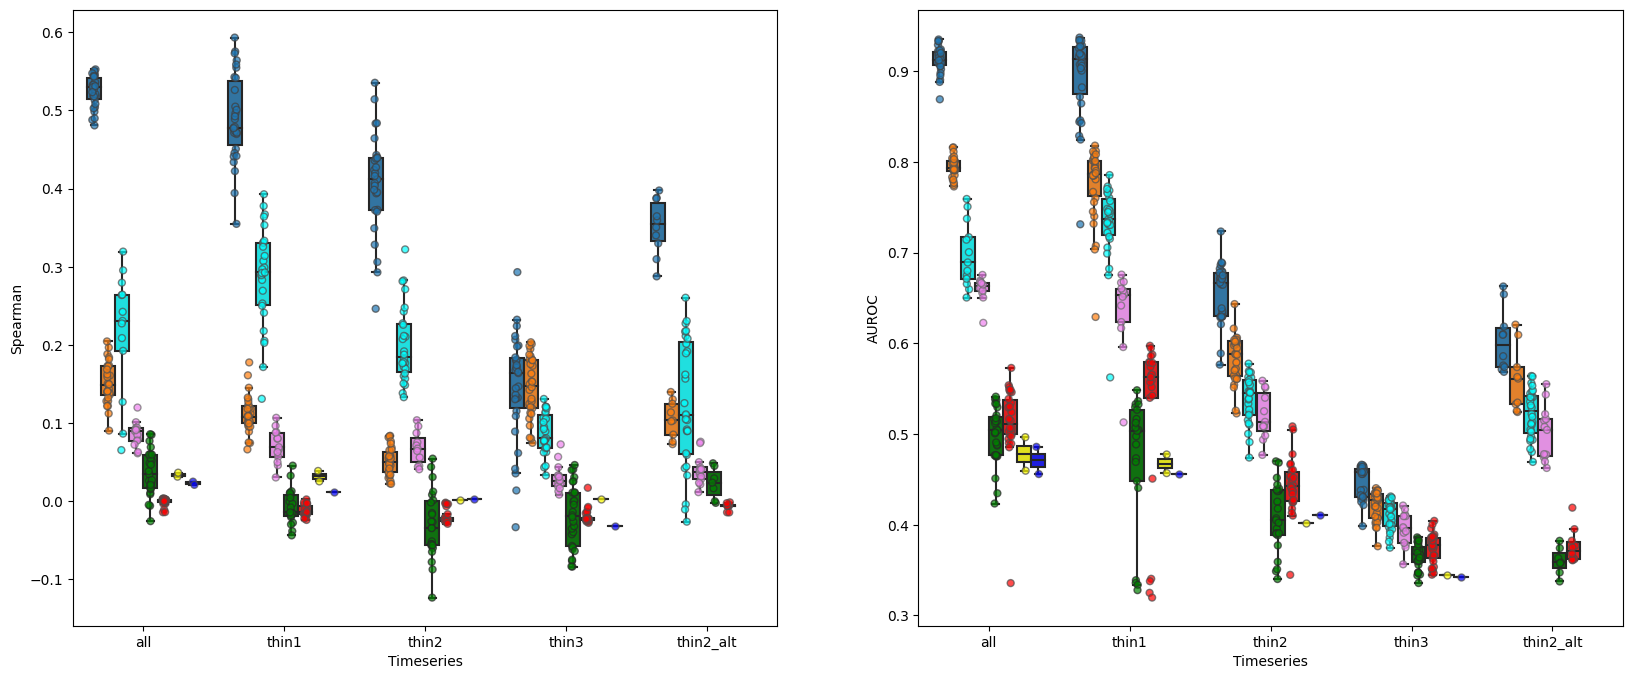

In [113]:
# ====================================================== Plotting code
# only plot replicates where all 4 methods finished.
# _interaction_method_counts = interaction_metric_thinning_df.groupby(["TrajReplicate", "NumPerts", "DataReplicate", "NumMice", "Timeseries"])['Method'].count().rename("MethodCount").reset_index()
# _interaction_df_to_plot = _interaction_method_counts.loc[_interaction_method_counts['MethodCount'] == 4].merge(
#     interaction_metric_thinning_df,
#     on=["TrajReplicate", "NumPerts", "DataReplicate", "NumMice", "Timeseries"],
#     how='left'
# )


fig, ax = plt.subplots(1, 2, figsize=(20, 8))
box_and_scatter_plot(
    interaction_metric_thinning_df, 
    ax[0], 
    x='Timeseries',
    y='Spearman', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'RA-MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net', 'glv-ra_elastic_net', 'glv-ra_ridge'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'RA-MDSINE2_nomodule': 'violet', 'glv_ridge': 'green', 'glv_elastic_net': 'red', 'glv-ra_elastic_net': 'yellow', 'glv-ra_ridge': 'blue'}, 
    title=None, 
    render_pvalues=False
)

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    ax[1],
    x='Timeseries',
    y='AUROC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'RA-MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net', 'glv-ra_elastic_net', 'glv-ra_ridge'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'RA-MDSINE2_nomodule': 'violet', 'glv_ridge': 'green', 'glv_elastic_net': 'red', 'glv-ra_elastic_net': 'yellow', 'glv-ra_ridge': 'blue'}, 
    title=None, 
    render_pvalues=False
)

# 4 (part 2). Interaction Prediction - Precision-Recall & Receiver-Operator curves

In [ ]:
def evaluate_mcmc_interactions_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    return evaluate_mcmc_interactions_prc_roc_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2', method_label='MDSINE2'
    )


def evaluate_mcmc_nomodule_interactions_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    return evaluate_mcmc_interactions_prc_roc_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
    )


def evaluate_mcmc_interactions_prc_roc_generic(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
    inference_cache_subdir: str, method_label: str
):
    true_interactions = synchronize_matrix_to_taxa(truth_glv.interactions, base_taxa, target_taxa_names)

    # try to load from cache
    instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
    cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
    cache_file = cache_subdir / "interactions_nanmean.npy"
    if cache_file.exists():
        nanmean_interactions = np.load(cache_subdir / "interactions_nanmean.npy")
        interaction_posterior_p = np.load(cache_subdir / "interaction_posterior_p.npy")
    else:
        if inference_cache_subdir == 'mdsine2':
            mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
        elif inference_cache_subdir == 'mdsine2_nomodule':
            mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
        mcmc_interactions = extract_interactions(mcmc)
        
        nanmean_interactions = np.nanmean(mcmc_interactions, axis=0)
        interaction_posterior_p = np.mean(~np.isnan(mcmc_interactions), axis=0)
        
        np.save(cache_subdir / "interactions_nanmean.npy", nanmean_interactions)
        np.save(cache_subdir / "interaction_posterior_p.npy", interaction_posterior_p)
    
    nanmean_interactions = synchronize_matrix_to_taxa(nanmean_interactions, instance_taxa, target_taxa_names)
    interaction_posterior_p = synchronize_matrix_to_taxa(interaction_posterior_p, instance_taxa, target_taxa_names)
    
    precision, recall, threshholds = precision_recall_curve(get_matrix_offdiag(true_interactions) != 0, get_matrix_offdiag(interaction_posterior_p))
    fpr, tpr, thresholds = roc_curve(get_matrix_offdiag(true_interactions) != 0, get_matrix_offdiag(interaction_posterior_p))
    return {
        'PRC': (recall, precision),
        'ROC': (fpr, tpr),
    }


def evaluate_regression_interactions_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
    model: str, opt: str, 
    target_taxa_names: List[str]
):    
    true_interactions = synchronize_matrix_to_taxa(truth_glv.interactions, base_taxa, target_taxa_names)
    pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
        traj_repl, perts, data_repl, n_mice, timeseries_id, 
        model, opt
    )
    instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
    pred_interactions = synchronize_matrix_to_taxa(pred_interactions, instance_taxa, target_taxa_names)
    
    pred_pvals, _ = regression_interaction_pvals(semisynthetic_outputs.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / 'regression', model, opt)
    pred_pvals[np.isnan(pred_pvals)] = 1.0
    pred_pvals = synchronize_matrix_to_taxa(pred_pvals, instance_taxa, target_taxa_names, fill_value=1.0)
    
    precision, recall, threshholds = precision_recall_curve(get_matrix_offdiag(true_interactions) != 0, get_matrix_offdiag(pred_pvals))
    fpr, tpr, thresholds = roc_curve(get_matrix_offdiag(true_interactions) != 0, get_matrix_offdiag(pred_pvals))
    return {
        'PRC': (recall, precision),
        'ROC': (fpr, tpr),
    }

In [ ]:
from collections import defaultdict


# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']

posterior_threshold = 0.5


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


interactions_mcmc_curves = defaultdict(list)
interactions_mcmc_nomodule_curves = defaultdict(list)
interactions_elastic_net_regression_curves = defaultdict(list)
interactions_ridge_regression_curves = defaultdict(list)

for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    try:
        interactions_mcmc_curves[timeseries_id].append(evaluate_mcmc_interactions_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold))
    except MCMCError as e:
        print(e)
    except FileNotFoundError as e:
        pass
        
    try:
        interactions_mcmc_nomodule_curves[timeseries_id].append(evaluate_mcmc_nomodule_interactions_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold))
    except MCMCError as e:
        print(e)
    except pickle.UnpicklingError as e:
        print(e)
    except FileNotFoundError as e:
        pass
        
    try:
        interactions_elastic_net_regression_curves[timeseries_id].append(evaluate_regression_interactions_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset))
        interactions_ridge_regression_curves[timeseries_id].append(evaluate_regression_interactions_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset))
    except FileNotFoundError as e:
        print(e)

# 5. [plot] Growth Rate

## Metric functions

In [17]:
from sklearn.metrics import roc_auc_score


def root_mean_square_error(pred, truth, eps: float = 1e-10) -> float:
    return np.sqrt(
        np.mean(
            np.square(
                np.log10(np.abs(pred) + eps) - np.log10(truth + eps)
            )
        )
    )


def growth_cosine_similarity(pred, truth) -> float:
    return (np.sum(pred * truth) / np.linalg.norm(truth)) / np.linalg.norm(pred)


def growth_spearman(pred, truth) -> float:
    return scipy.stats.spearmanr(pred, truth)[0]

## Helper code: per-method evaluation (With caching)

In [18]:
def evaluate_mcmc_growths(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str],
):
    evaluate_mcmc_growths_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names,
        inference_cache_subdir='mdsine2', method_label='MDSINE2'
    )


def evaluate_mcmc_nomodule_growths(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str],
):
    evaluate_mcmc_growths_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names,
        inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
    )


def evaluate_mcmc_ra_growths(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str],
):
    evaluate_mcmc_growths_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names,
        inference_cache_subdir='mdsine2_ra', method_label='RA-MDSINE2'
    )


def evaluate_mcmc_ra_nomodule_growths(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str],
):
    evaluate_mcmc_growths_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names,
        inference_cache_subdir='mdsine2_ra_nomodule', method_label='RA-MDSINE2_nomodule'
    )


def evaluate_mcmc_growths_generic(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str],
    inference_cache_subdir: str,
    method_label: str
):
    try:
        true_growths = synchronize_array_to_taxa(truth_glv.growth, base_taxa, target_taxa_names)
    
        # try to load from cache
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
        cache_file = cache_subdir / "growths_nanmean.npy"
        if cache_file.exists():
            nanmean_growths = np.load(cache_subdir / "growths_nanmean.npy")
        else:
            if inference_cache_subdir == 'mdsine2':
                mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_nomodule':
                mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_ra':
                mcmc = semisynthetic_outputs.get_mdsine2_ra(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_ra_nomodule':
                mcmc = semisynthetic_outputs.get_mdsine2_ra_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
            mcmc_growths = extract_growths(mcmc)
            nanmean_growths = np.nanmean(mcmc_growths, axis=0)
            np.save(cache_subdir / "growths_nanmean.npy", nanmean_growths)
        
        nanmean_growths = synchronize_array_to_taxa(nanmean_growths, instance_taxa, target_taxa_names)
        df_entries.append({
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': method_label,
            'CosineSimilarity': growth_cosine_similarity(nanmean_growths, true_growths),
            'Spearman': growth_spearman(nanmean_growths, true_growths),
            'RMSlog': root_mean_square_error(nanmean_growths, true_growths),
        })
    except MCMCError as e:
        print(e)
    except FileNotFoundError as e:
        pass


def evaluate_regression_growths(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
    model: str, opt: str, 
    target_taxa_names: List[str]
):    
    try:
        true_growths = synchronize_array_to_taxa(truth_glv.growth, base_taxa, target_taxa_names)
        pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
            traj_repl, perts, data_repl, n_mice, timeseries_id, 
            model, opt
        )
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        pred_growths = synchronize_array_to_taxa(pred_growths, instance_taxa, target_taxa_names)
        
        df_entries.append({
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': f'{model}_{opt}',
            'CosineSimilarity': growth_cosine_similarity(pred_growths, true_growths),
            'Spearman': growth_spearman(pred_growths, true_growths),
            'RMSlog': root_mean_square_error(pred_growths, true_growths),
        })
    except FileNotFoundError as e:
        pass

## Plot: Growth Metrics (Timepoint thinning)

  0%|          | 0/120 [00:00<?, ?it/s]

using the UNION strategy.
['OTU_1', 'OTU_10', 'OTU_101', 'OTU_103', 'OTU_105', 'OTU_107', 'OTU_108', 'OTU_11', 'OTU_111', 'OTU_114', 'OTU_115', 'OTU_117', 'OTU_118', 'OTU_12', 'OTU_120', 'OTU_122', 'OTU_123', 'OTU_124', 'OTU_127', 'OTU_128', 'OTU_129', 'OTU_13', 'OTU_130', 'OTU_132', 'OTU_133', 'OTU_134', 'OTU_137', 'OTU_14', 'OTU_140', 'OTU_144', 'OTU_145', 'OTU_15', 'OTU_153', 'OTU_154', 'OTU_156', 'OTU_16', 'OTU_169', 'OTU_17', 'OTU_171', 'OTU_177', 'OTU_18', 'OTU_19', 'OTU_2', 'OTU_20', 'OTU_21', 'OTU_22', 'OTU_23', 'OTU_24', 'OTU_25', 'OTU_26', 'OTU_28', 'OTU_29', 'OTU_3', 'OTU_30', 'OTU_31', 'OTU_32', 'OTU_33', 'OTU_34', 'OTU_35', 'OTU_36', 'OTU_37', 'OTU_38', 'OTU_4', 'OTU_40', 'OTU_41', 'OTU_42', 'OTU_43', 'OTU_44', 'OTU_45', 'OTU_48', 'OTU_49', 'OTU_5', 'OTU_50', 'OTU_52', 'OTU_53', 'OTU_54', 'OTU_57', 'OTU_58', 'OTU_59', 'OTU_6', 'OTU_60', 'OTU_61', 'OTU_63', 'OTU_64', 'OTU_65', 'OTU_66', 'OTU_67', 'OTU_69', 'OTU_7', 'OTU_70', 'OTU_75', 'OTU_77', 'OTU_78', 'OTU_79', 'OTU_8', 

  0%|          | 0/120 [00:00<?, ?it/s]

[WARNING] mcmc pickle from 4|3|0|4|thin2|mdsine2|synthetic only contains 1900 samples.
[WARNING] mcmc pickle from 5|3|0|4|all|mdsine2|synthetic_nomodule only contains 9600 samples.
[WARNING] mcmc pickle from 6|3|1|4|thin1|mdsine2_ra|synthetic only contains 5000 samples.


,TrajReplicate,NumPerts,DataReplicate,NumMice,Timeseries,Method,CosineSimilarity,Spearman,RMSlog
0,0,3,0,4,all,MDSINE2,0.876223,0.749601,1.422848
1,0,3,0,4,all,MDSINE2_nomodule,0.952158,0.867303,1.333023
2,0,3,0,4,all,RA-MDSINE2,0.648510,0.325469,1.619161
3,0,3,0,4,all,RA-MDSINE2_nomodule,0.921274,0.761342,1.316298
4,0,3,0,4,all,glv_elastic_net,0.584712,0.586027,1.993730
...,...,...,...,...,...,...,...,...,...
897,9,3,2,4,thin3,RA-MDSINE2,0.682718,0.057876,4.803448
898,9,3,2,4,thin3,RA-MDSINE2_nomodule,0.778969,0.330101,4.781402
899,9,3,2,4,thin3,glv_ridge,0.599202,0.313353,4.784584
900,9,3,2,4,thin3,glv-ra_elastic_net,0.647664,0.445620,4.964456


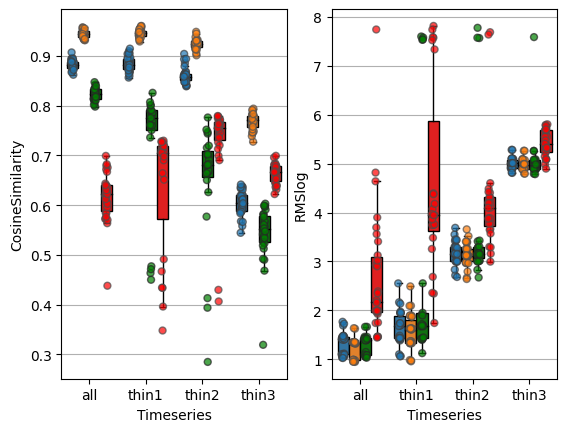

In [19]:
# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


df_entries = []
for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    # taxa_subset = get_taxa_collection([(traj_repl, perts, data_repl, n_mice, timeseries_id)])  # only do this if we don't want to do any intersection/union.
    evaluate_mcmc_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
    evaluate_mcmc_nomodule_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
    evaluate_mcmc_ra_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
    evaluate_mcmc_ra_nomodule_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
        
    evaluate_regression_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset)
    evaluate_regression_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset)
    evaluate_regression_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'elastic_net', taxa_subset)
    evaluate_regression_growths(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'ridge', taxa_subset)

# print(subset)
growth_metric_thinning_df = pd.DataFrame(df_entries)
del df_entries


# ====================================================== Plotting code
fig, ax = plt.subplots(1, 2)
box_and_scatter_plot(
    growth_metric_thinning_df, 
    ax[0], 
    x='Timeseries', y='CosineSimilarity', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    growth_metric_thinning_df, 
    ax[1], 
    x='Timeseries', y='RMSlog',
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
display(growth_metric_thinning_df)

# 6. [plot] Co-clustering

## Metric functions

In [20]:
def coclustering_error(pred, truth):
    """ Given two co-clustering likelihood matrix (truth is a binary matrix, truth is a matrix with entries in [0,1]), evaluate the error. """
    return np.mean(np.abs(pred - truth))


def coclustering_auroc(pred, truth):
    """ Evaluate the AUC-ROC of coclustering (given binary ground truth matrix and a predicted pairwise score matrix). """
    pred = off_diagonal_entries(pred)
    truth = off_diagonal_entries(truth)
    return sklearn.metrics.roc_auc_score(y_true=truth, y_score=pred)


def create_consensus_cluster(n_clusters_all: np.ndarray, matrices: np.ndarray) -> np.ndarray:
    A = np.mean(matrices, axis=0)
    n = scipy.stats.mode(n_clusters_all)[0][0]
    c = AgglomerativeClustering(
        n_clusters=n,
        affinity='precomputed',
        linkage='complete'
    )
    ret = c.fit_predict(1 - A)  # A is a similarity metric; 1-A is distance
    return ret

## Evaluation function

In [21]:
def evaluate_mdsine2_coclustering(traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str]):
    evaluate_mdsine2_coclustering_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, "mdsine2", 'MDSINE2')


def evaluate_mdsine2_ra_coclustering(traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str]):
    evaluate_mdsine2_coclustering_generic(traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, "mdsine2_ra", 'RA-MDSINE2')


def evaluate_mdsine2_coclustering_generic(traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], inference_cache_subdir: str, method_label: str):
    true_coclustering = synchronize_matrix_to_taxa(truth_coclust, base_taxa, target_taxa_names)
    
    # try to load from cache
    instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
    cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
    cache_file = cache_subdir / "coclustering_p.npy"
    if cache_file.exists():
        coclustering_p = np.load(cache_file)
    else:
        if inference_cache_subdir == 'mdsine2':
            mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
        elif inference_cache_subdir == "mdsine2_ra":
            mcmc = semisynthetic_outputs.get_mdsine2_ra(traj_repl, perts, data_repl, n_mice, timeseries_id)
        mcmc_coclusterings = extract_coclusterings(mcmc)
        coclustering_p = np.mean(mcmc_coclusterings, axis=0)
        np.save(cache_file, coclustering_p)

    coclustering_p = synchronize_matrix_to_taxa(coclustering_p, instance_taxa, target_taxa_names)
    df_entries.append({
        'TrajReplicate': traj_repl,
        'NumPerts': perts,
        'DataReplicate': data_repl,
        'NumMice': n_mice,
        'Timeseries': timeseries_id,
        'Method': method_label,
        'CoclustAUROC': coclustering_auroc(coclustering_p, true_coclustering)
    })

## Plot

In [22]:
# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


df_entries = []
for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    # taxa_subset = get_taxa_collection([(traj_repl, perts, data_repl, n_mice, timeseries_id)])  # only do this if we don't want to do any intersection/union.
    
    try:
        evaluate_mdsine2_coclustering(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
    except MCMCError as e:
        print(e)
    except FileNotFoundError as e:
        pass
    
    try:
        evaluate_mdsine2_ra_coclustering(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset)
    except MCMCError as e:
        print(e)
    except FileNotFoundError as e:
        pass

coclust_metric_thinning_df = pd.DataFrame(df_entries)
del df_entries
display(coclust_metric_thinning_df)

  0%|          | 0/120 [00:00<?, ?it/s]

using the UNION strategy.
['OTU_1', 'OTU_10', 'OTU_101', 'OTU_103', 'OTU_105', 'OTU_107', 'OTU_108', 'OTU_11', 'OTU_111', 'OTU_114', 'OTU_115', 'OTU_117', 'OTU_118', 'OTU_12', 'OTU_120', 'OTU_122', 'OTU_123', 'OTU_124', 'OTU_127', 'OTU_128', 'OTU_129', 'OTU_13', 'OTU_130', 'OTU_132', 'OTU_133', 'OTU_134', 'OTU_137', 'OTU_14', 'OTU_140', 'OTU_144', 'OTU_145', 'OTU_15', 'OTU_153', 'OTU_154', 'OTU_156', 'OTU_16', 'OTU_169', 'OTU_17', 'OTU_171', 'OTU_177', 'OTU_18', 'OTU_19', 'OTU_2', 'OTU_20', 'OTU_21', 'OTU_22', 'OTU_23', 'OTU_24', 'OTU_25', 'OTU_26', 'OTU_28', 'OTU_29', 'OTU_3', 'OTU_30', 'OTU_31', 'OTU_32', 'OTU_33', 'OTU_34', 'OTU_35', 'OTU_36', 'OTU_37', 'OTU_38', 'OTU_4', 'OTU_40', 'OTU_41', 'OTU_42', 'OTU_43', 'OTU_44', 'OTU_45', 'OTU_48', 'OTU_49', 'OTU_5', 'OTU_50', 'OTU_52', 'OTU_53', 'OTU_54', 'OTU_57', 'OTU_58', 'OTU_59', 'OTU_6', 'OTU_60', 'OTU_61', 'OTU_63', 'OTU_64', 'OTU_65', 'OTU_66', 'OTU_67', 'OTU_69', 'OTU_7', 'OTU_70', 'OTU_75', 'OTU_77', 'OTU_78', 'OTU_79', 'OTU_8', 

  0%|          | 0/120 [00:00<?, ?it/s]

[WARNING] mcmc pickle from 4|3|0|4|thin2|mdsine2|synthetic only contains 1900 samples.
[WARNING] mcmc pickle from 6|3|1|4|thin1|mdsine2_ra|synthetic only contains 5000 samples.


,TrajReplicate,NumPerts,DataReplicate,NumMice,Timeseries,Method,CoclustAUROC
0,0,3,0,4,all,MDSINE2,0.736171
1,0,3,0,4,all,RA-MDSINE2,0.620100
2,0,3,0,4,thin1,MDSINE2,0.691479
3,0,3,0,4,thin1,RA-MDSINE2,0.629809
4,0,3,0,4,thin2,MDSINE2,0.684549
...,...,...,...,...,...,...,...
221,9,3,2,4,thin1,RA-MDSINE2,0.635996
222,9,3,2,4,thin2,MDSINE2,0.644639
223,9,3,2,4,thin2,RA-MDSINE2,0.646510
224,9,3,2,4,thin3,MDSINE2,0.668450


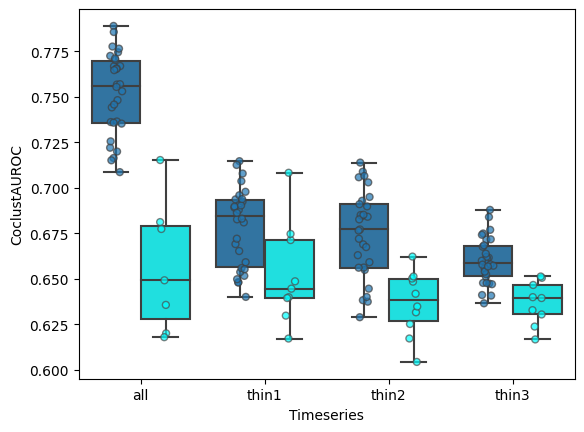

In [139]:
# ====================================================== Plotting code
fig, ax = plt.subplots(1, 1)
box_and_scatter_plot(
    coclust_metric_thinning_df, 
    ax, 
    x='Timeseries', y='CoclustAUROC', 
    method_order=['MDSINE2', 'RA-MDSINE2'], 
    method_colors={'MDSINE2': 'tab:blue', 'RA-MDSINE2': 'cyan'}, 
    title=None, 
    render_pvalues=False
)

In [140]:
# sb.stripplot(
#     coclust_metric_thinning_df.loc[coclust_metric_thinning_df['Timeseries'] == 'thin3'],
#     x='TrajReplicate',
#     hue='DataReplicate',
#     y='CoclustAUROC',
# )

# # box_and_scatter_plot(
# #     coclust_metric_thinning_df, 
# #     ax, 
# #     x='Timeseries', y='CoclustAUROC', 
# #     method_order=['MDSINE2'], 
# #     method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
# #     title=None, 
# #     render_pvalues=False
# # )

# 7. [plot] Perturbation

## Metric functions

In [23]:
def perturbation_rmse(pred: np.ndarray, truth: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(pred - truth)))
    # if pred.ndim == 1:
    #     return np.sqrt(np.mean(np.square(pred - truth)))
    # elif pred.ndim == 2:
    #     return np.sqrt(
    #         np.mean(
    #             np.square(pred-truth),
    #             axis=-1
    #         )
    #     )
    # else:
    #     raise ValueError("Unknown pred shape for perturbation: {}".format(pred.shape))


def perturbation_cosine_sim(pred, truth):
    return (np.sum(pred * truth) / np.linalg.norm(truth)) / np.linalg.norm(pred)


def pert_prediction_auroc(pred_scores: np.ndarray, truth: np.ndarray) -> float:
    truth = (truth != 0.0)
    return roc_auc_score(truth.flatten(), pred_scores.flatten())


def pert_prediction_auprc(pred_scores: np.ndarray, truth: np.ndarray) -> float:
    truth = (truth != 0.0)
    precision, recall, thresholds = precision_recall_curve(truth.flatten(), pred_scores.flatten())
    return auc(recall, precision)


# Note: need to convert from r+B model to r(1+\gamma) model for regression.

# # convert from r(1+\gamma) model to r+B model
# truth_perts_additive = [truth_glv.growth * p for p in truth_glv.perturbations]

## Evaluation function

In [24]:
def evaluate_mcmc_perturbations(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_perturbations_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2', method_label='MDSINE2'
    )


def evaluate_mcmc_nomodule_perturbations(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_perturbations_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
    )


def evaluate_mcmc_ra_perturbations(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_perturbations_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_ra', method_label='RA-MDSINE2'
    )


def evaluate_mcmc_ra_nomodule_perturbations(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    evaluate_mcmc_perturbations_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_ra_nomodule', method_label='RA-MDSINE2_nomodule'
    )


def evaluate_mcmc_perturbations_generic(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
    inference_cache_subdir: str,
    method_label: str
):
    try:
        true_perts = np.stack(
            [
                synchronize_array_to_taxa(p, base_taxa, target_taxa_names)
                for p in truth_glv.perturbations
            ], 
            axis=0
        )
        pert_ordering = [p.name for p in base_study.perturbations]
        
        # try to load from cache
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
        cache_file = cache_subdir / "perts_nanmean.npy"
        if cache_file.exists():
            nanmean_perts = np.load(cache_file)
            perts_posterior_p = np.load(cache_subdir / "perts_probs.npy")
        else:
            if inference_cache_subdir == 'mdsine2':
                mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_nomodule':
                mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_ra':
                mcmc = semisynthetic_outputs.get_mdsine2_ra(traj_repl, perts, data_repl, n_mice, timeseries_id)
            elif inference_cache_subdir == 'mdsine2_ra_nomodule':
                mcmc = semisynthetic_outputs.get_mdsine2_ra_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)
    
            nanmean_perts = []
            perts_posterior_p = []
            for p_name in pert_ordering:
                mcmc_pert_values = extract_perts(mcmc, p_name)
                nanmean_perts.append(np.nanmean(mcmc_pert_values, axis=0))
                perts_posterior_p.append(np.mean(~np.isnan(mcmc_pert_values), axis=0))
            nanmean_perts = np.stack(nanmean_perts, axis=0)
            perts_posterior_p = np.stack(perts_posterior_p, axis=0)
            np.save(cache_file, nanmean_perts)
            np.save(cache_subdir / "perts_probs.npy", perts_posterior_p)
        
        nanmean_perts = np.stack(
            [
                synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
                for p in nanmean_perts
            ],
            axis=0
        )
        perts_posterior_p = np.stack(
            [
                synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
                for p in perts_posterior_p
            ],
            axis=0
        )
    
        # some entries are still nan (if nanmean was asked to evaluate the mean on an array of all-nans). set those to zero.
        nanmean_perts[np.isnan(nanmean_perts)] = 0.
        nanmean_perts[perts_posterior_p <= posterior_threshold] = 0.
        
        entry = {
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': method_label,
            'CosineSimilarity': perturbation_cosine_sim(nanmean_perts, true_perts),
            'AUROC': pert_prediction_auroc(perts_posterior_p, true_perts),
            'AUPRC': pert_prediction_auprc(perts_posterior_p, true_perts),
            'RMSE': perturbation_rmse(nanmean_perts, true_perts),
            'Spearman': scipy.stats.spearmanr(nanmean_perts.flatten(), true_perts.flatten())[0]
        }
        for pert_idx, pert_name in enumerate(pert_ordering):
            entry[f'CosineSimilarity_{pert_name}'] = perturbation_cosine_sim(nanmean_perts[pert_idx], true_perts[pert_idx])
            entry[f'AUROC_{pert_name}'] = pert_prediction_auroc(perts_posterior_p[pert_idx], true_perts[pert_idx])
            entry[f'AUPRC_{pert_name}'] = pert_prediction_auprc(perts_posterior_p[pert_idx], true_perts[pert_idx])
            entry[f'RMSE_{pert_name}'] = perturbation_rmse(nanmean_perts[pert_idx], true_perts[pert_idx])
            entry[f'Spearman_{pert_name}'] = scipy.stats.spearmanr(nanmean_perts[pert_idx], true_perts[pert_idx])[0]
        df_entries.append(entry)
    except MCMCError as e:
        print(e)
    except pickle.UnpicklingError as e:
        print(e)
    except FileNotFoundError as e:
        pass


def evaluate_regression_perturbations(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
    model: str, opt: str, 
    target_taxa_names: List[str]
):    
    try:
        true_perts = np.stack(
            [
                synchronize_array_to_taxa(p, base_taxa, target_taxa_names)
                for p in truth_glv.perturbations
            ], 
            axis=0
        )
        pert_ordering = [p.name for p in base_study.perturbations]
        
        pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
            traj_repl, perts, data_repl, n_mice, timeseries_id, 
            model, opt
        )
        """
        Regression code's perturbation needs to be adjusted. The authors' GLV/CLV model is a (r+B) model, while mdsine2 is r(1+\gamma).
        The conversion is: \gamma = B / r. Note that if r=0 (which could be the case in the regression solutions), then this is undefined.
        """
        instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
        pred_perts_gamma = np.stack(
            [
                synchronize_array_to_taxa(p / pred_growths, instance_taxa, target_taxa_names)  # divide by growth rate.
                for p in pred_perts.T  # also swap the shape from (N_taxa, N_perts) into (N_perts, N_taxa)
            ],
            axis=0
        )
        pred_perts_gamma[np.isnan(pred_perts_gamma)] = 0.0  # fill in invalid perturbation values
    
        _, pert_pvals = regression_interaction_pvals(semisynthetic_outputs.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / 'regression', model, opt)
        pert_pvals[np.isnan(pert_pvals)] = 1.0
        pert_pvals = np.stack(
            [
                synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
                for p in pert_pvals
            ],
            axis=0
        )
    
        entry = {
            'TrajReplicate': traj_repl,
            'NumPerts': perts,
            'DataReplicate': data_repl,
            'NumMice': n_mice,
            'Timeseries': timeseries_id,
            'Method': f'{model}_{opt}',
            'CosineSimilarity': perturbation_cosine_sim(pred_perts_gamma, true_perts),
            'AUROC': pert_prediction_auroc(1-pert_pvals, true_perts),
            'AUPRC': pert_prediction_auprc(1-pert_pvals, true_perts),
            'RMSE': perturbation_rmse(pred_perts_gamma, true_perts),
            'Spearman': scipy.stats.spearmanr(pred_perts_gamma.flatten(), true_perts.flatten())[0]
        }
        for pert_idx, pert_name in enumerate(pert_ordering):
            entry[f'CosineSimilarity_{pert_name}'] = perturbation_cosine_sim(pred_perts_gamma[pert_idx], true_perts[pert_idx])
            entry[f'AUROC_{pert_name}'] = pert_prediction_auroc(1-pert_pvals[pert_idx], true_perts[pert_idx])
            entry[f'AUPRC_{pert_name}'] = pert_prediction_auprc(1-pert_pvals[pert_idx], true_perts[pert_idx])
            entry[f'RMSE_{pert_name}'] = perturbation_rmse(pred_perts_gamma[pert_idx], true_perts[pert_idx])
            entry[f'Spearman_{pert_name}'] = scipy.stats.spearmanr(pred_perts_gamma[pert_idx], true_perts[pert_idx])[0]
        df_entries.append(entry)
    except FileNotFoundError as e:
        print(e)

## Plot

In [41]:
# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
# data_repls_arr = [0]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3', 'thin2_alt']

posterior_threshold = 0.50


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


df_entries = []
for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    # taxa_subset = get_taxa_collection([(traj_repl, perts, data_repl, n_mice, timeseries_id)])  # only do this if we don't want to do any intersection/union.
    
    evaluate_mcmc_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
    evaluate_mcmc_nomodule_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
    evaluate_mcmc_ra_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
    evaluate_mcmc_ra_nomodule_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
    
    evaluate_regression_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset)
    evaluate_regression_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset)
    evaluate_regression_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'elastic_net', taxa_subset)
    evaluate_regression_perturbations(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv-ra', 'ridge', taxa_subset)

# print(subset)
pert_metric_thinning_df = pd.DataFrame(df_entries)
del df_entries
display(pert_metric_thinning_df)

  0%|          | 0/150 [00:00<?, ?it/s]

using the UNION strategy.
['OTU_1', 'OTU_10', 'OTU_101', 'OTU_103', 'OTU_105', 'OTU_107', 'OTU_108', 'OTU_11', 'OTU_111', 'OTU_114', 'OTU_115', 'OTU_117', 'OTU_118', 'OTU_12', 'OTU_120', 'OTU_122', 'OTU_123', 'OTU_124', 'OTU_127', 'OTU_128', 'OTU_129', 'OTU_13', 'OTU_130', 'OTU_132', 'OTU_133', 'OTU_134', 'OTU_137', 'OTU_14', 'OTU_140', 'OTU_144', 'OTU_145', 'OTU_15', 'OTU_153', 'OTU_154', 'OTU_156', 'OTU_16', 'OTU_169', 'OTU_17', 'OTU_171', 'OTU_177', 'OTU_18', 'OTU_19', 'OTU_2', 'OTU_20', 'OTU_21', 'OTU_22', 'OTU_23', 'OTU_24', 'OTU_25', 'OTU_26', 'OTU_28', 'OTU_29', 'OTU_3', 'OTU_30', 'OTU_31', 'OTU_32', 'OTU_33', 'OTU_34', 'OTU_35', 'OTU_36', 'OTU_37', 'OTU_38', 'OTU_4', 'OTU_40', 'OTU_41', 'OTU_42', 'OTU_43', 'OTU_44', 'OTU_45', 'OTU_48', 'OTU_49', 'OTU_5', 'OTU_50', 'OTU_52', 'OTU_53', 'OTU_54', 'OTU_57', 'OTU_58', 'OTU_59', 'OTU_6', 'OTU_60', 'OTU_61', 'OTU_63', 'OTU_64', 'OTU_65', 'OTU_66', 'OTU_67', 'OTU_69', 'OTU_7', 'OTU_70', 'OTU_75', 'OTU_77', 'OTU_78', 'OTU_79', 'OTU_8', 

  0%|          | 0/150 [00:00<?, ?it/s]

Regression for glv-ra, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_0/mice_4/timepoints_thin2_alt/regression not yet done.
Regression for glv-ra, ridge in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_0/mice_4/timepoints_thin2_alt/regression not yet done.
Regression for glv-ra, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_1/mice_4/timepoints_thin2_alt/regression not yet done.
Regression for glv-ra, ridge in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_1/mice_4/timepoints_thin2_alt/regression not yet done.
Unable to locate any .pkl files in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_2/mice_4/timepoints_thin2_alt/regression.
Regression for glv-ra, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_0/perts_3/data_repl_2/mice_4/timepoints_thin2_alt/regression not yet done.
Regression for

,TrajReplicate,NumPerts,DataReplicate,NumMice,Timeseries,Method,CosineSimilarity,AUROC,AUPRC,RMSE,...,CosineSimilarity_Vancomycin,AUROC_Vancomycin,AUPRC_Vancomycin,RMSE_Vancomycin,Spearman_Vancomycin,CosineSimilarity_Gentamicin,AUROC_Gentamicin,AUPRC_Gentamicin,RMSE_Gentamicin,Spearman_Gentamicin
0,0,3,0,4,all,MDSINE2,0.216218,0.930788,0.947002,9.398006,...,0.349347,0.833333,0.984515,5.562299,0.516629,0.133210,0.970000,0.300000,12.945759,0.717539
1,0,3,0,4,all,MDSINE2_nomodule,0.127027,0.915929,0.941912,4.946973,...,0.579913,0.928571,0.993955,2.004637,0.618550,0.285248,0.986667,0.683333,2.150629,0.594135
2,0,3,0,4,all,RA-MDSINE2,0.562641,0.547296,0.734614,102.771015,...,0.776734,0.665923,0.971018,163.215926,0.686726,0.058677,0.513333,0.028878,50.110535,0.264489
3,0,3,0,4,all,RA-MDSINE2_nomodule,0.044437,0.849544,0.886996,3.069375,...,0.453620,0.771577,0.981884,2.279934,0.612215,0.186765,0.966667,0.291667,0.892003,0.418405
4,0,3,0,4,all,glv_elastic_net,NaN,0.651705,0.721594,inf,...,0.567109,0.584821,0.959756,2.290503,0.581898,NaN,0.583333,0.034548,inf,0.098079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,9,3,2,4,thin3,glv_ridge,0.220922,0.568072,0.677852,2.231744,...,0.534449,0.531250,0.942863,1.954927,0.174747,-0.004349,0.616667,0.368809,1.062855,0.144733
990,9,3,2,4,thin3,glv-ra_elastic_net,NaN,0.519593,0.657640,inf,...,NaN,0.568452,0.946621,inf,NaN,NaN,0.630000,0.369198,inf,0.120268
991,9,3,2,4,thin3,glv-ra_ridge,-0.044808,0.518191,0.655173,13.166838,...,0.095159,0.558036,0.945263,8.933102,0.049188,-0.006587,0.716667,0.372901,4.514859,0.138865
992,9,3,2,4,thin2_alt,RA-MDSINE2,0.334634,0.698124,0.814653,7.783811,...,0.755308,0.737351,0.977902,5.592910,0.626115,0.000000,0.438333,0.025566,3.781635,0.034807


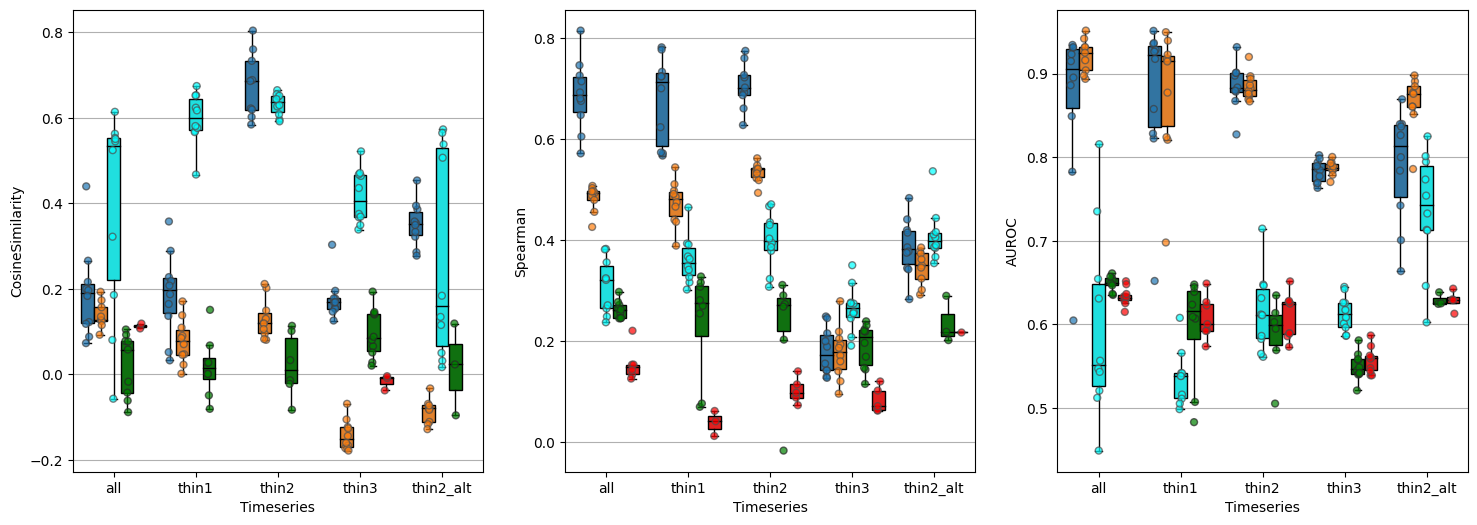

In [42]:
# ====================================================== Plotting code
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[0], 
    x='Timeseries', y='CosineSimilarity', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[1], 
    x='Timeseries', y='Spearman', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[2], 
    x='Timeseries', y='AUROC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

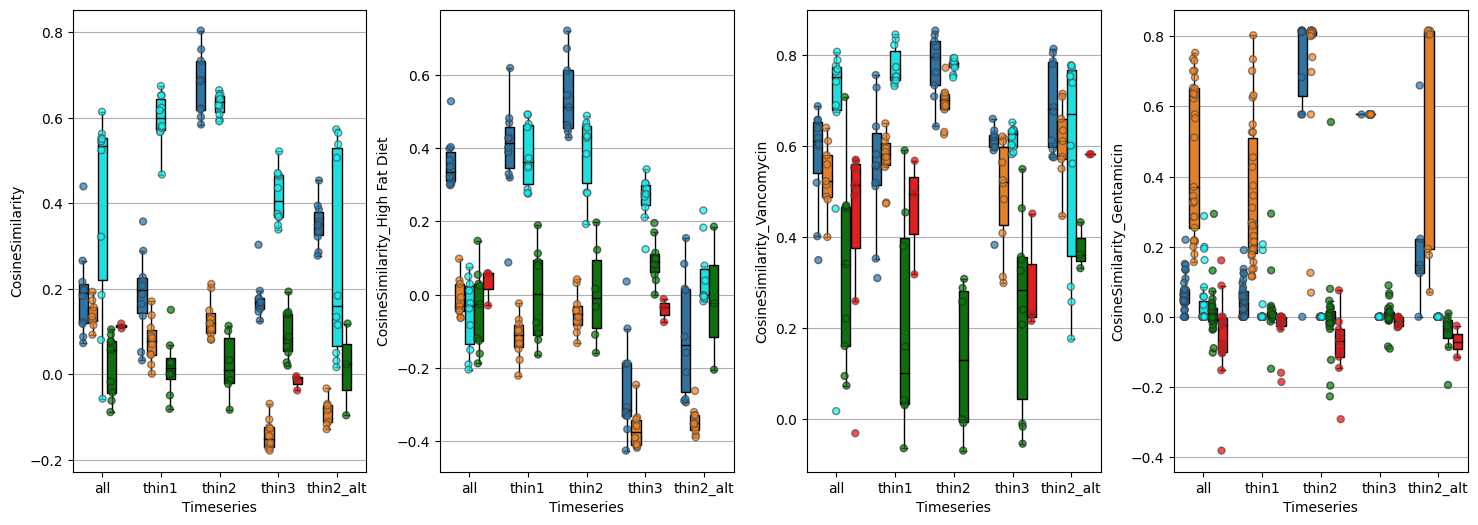

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'wspace': 0.25})
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[0], 
    x='Timeseries', y='CosineSimilarity', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[1], 
    x='Timeseries', y='CosineSimilarity_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df.loc[pert_metric_thinning_df['DataReplicate'] == 0], 
    ax[2], 
    x='Timeseries', y='CosineSimilarity_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[3], 
    x='Timeseries', y='CosineSimilarity_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'RA-MDSINE2', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'RA-MDSINE2': 'cyan', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
# plt.savefig("plots/perts_extra.pdf")

# 7 (part 2) -- Perturbation Precision-Recall & Receiver-Operator curves

In [270]:
def plot_curve_family(curves, ax, lineplot_kwargs={}):
    """
    :param: a list of tuples (x_vals, y_vals), where each such tuple describes a single curve.
    """
    df_entries = []
    for curve_id, (x_values, y_values) in enumerate(curves):
        for (x, y) in zip(x_values, y_values):
            df_entries.append({
                "cid": curve_id,
                "x": x, "y": y,
            })
    df = pd.DataFrame(df_entries)
    del df_entries

    sb.lineplot(data=df, x="x", y="y", ax=ax, errorbar=('ci', 95), **lineplot_kwargs)

In [271]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score


def evaluate_mcmc_perts_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    return evaluate_mcmc_perts_prc_roc_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2', method_label='MDSINE2'
    )


def evaluate_mcmc_nomodule_perts_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
):
    return evaluate_mcmc_perts_prc_roc_generic(
        traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
        inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
    )


def evaluate_mcmc_perts_prc_roc_generic(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
    inference_cache_subdir: str,
    method_label: str
):
    true_perts = np.stack(
        [
            synchronize_array_to_taxa(p, base_taxa, target_taxa_names)
            for p in truth_glv.perturbations
        ], 
        axis=0
    )
    pert_ordering = [p.name for p in base_study.perturbations]
    
    # try to load from cache
    instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
    cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
    cache_file = cache_subdir / "perts_nanmean.npy"
    if cache_file.exists():
        nanmean_perts = np.load(cache_file)
        perts_posterior_p = np.load(cache_subdir / "perts_probs.npy")
    else:
        if inference_cache_subdir == 'mdsine2':
            mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
        elif inference_cache_subdir == 'mdsine2_nomodule':
            mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)

        nanmean_perts = []
        perts_posterior_p = []
        for p_name in pert_ordering:
            mcmc_pert_values = extract_perts(mcmc, p_name)
            nanmean_perts.append(np.nanmean(mcmc_pert_values, axis=0))
            perts_posterior_p.append(np.mean(~np.isnan(mcmc_pert_values), axis=0))
        nanmean_perts = np.stack(nanmean_perts, axis=0)
        perts_posterior_p = np.stack(perts_posterior_p, axis=0)
        np.save(cache_file, nanmean_perts)
        np.save(cache_subdir / "perts_probs.npy", perts_posterior_p)
    
    nanmean_perts = np.stack(
        [
            synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
            for p in nanmean_perts
        ],
        axis=0
    )
    perts_posterior_p = np.stack(
        [
            synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
            for p in perts_posterior_p
        ],
        axis=0
    )

    # some entries are still nan (if nanmean was asked to evaluate the mean on an array of all-nans). set those to zero.
    nanmean_perts[np.isnan(nanmean_perts)] = 0.
    nanmean_perts[perts_posterior_p <= posterior_threshold] = 0.

    true_perts = (true_perts != 0.0)
    precision, recall, threshholds = precision_recall_curve(true_perts.flatten(), perts_posterior_p.flatten())
    fpr, tpr, thresholds = roc_curve(true_perts.flatten(), perts_posterior_p.flatten())
    auroc = roc_auc_score(true_perts.flatten(), perts_posterior_p.flatten())
    curves = {
        'PRC': (recall, precision),
        'ROC': (fpr, tpr),
    }
    for pert_idx, pert_name in enumerate(pert_ordering):
        precision, recall, threshholds = precision_recall_curve(true_perts[pert_idx], perts_posterior_p[pert_idx])
        fpr, tpr, thresholds = roc_curve(true_perts[pert_idx], perts_posterior_p[pert_idx])
        auroc = roc_auc_score(true_perts[pert_idx], perts_posterior_p[pert_idx])
        
        curves[f'PRC_{pert_name}'] = (recall, precision)
        curves[f'ROC_{pert_name}'] = (fpr, tpr)
    return curves


def evaluate_regression_perts_prc_roc(
    traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
    model: str, opt: str, 
    target_taxa_names: List[str]
):    
    true_perts = np.stack(
        [
            synchronize_array_to_taxa(p, base_taxa, target_taxa_names)
            for p in truth_glv.perturbations
        ], 
        axis=0
    )
    pert_ordering = [p.name for p in base_study.perturbations]
    
    pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
        traj_repl, perts, data_repl, n_mice, timeseries_id, 
        model, opt
    )
    """
    Regression code's perturbation needs to be adjusted. The authors' GLV/CLV model is a (r+B) model, while mdsine2 is r(1+\gamma).
    The conversion is: \gamma = B / r. Note that if r=0 (which could be the case in the regression solutions), then this is undefined.
    """
    instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
    pred_perts_gamma = np.stack(
        [
            synchronize_array_to_taxa(p / pred_growths, instance_taxa, target_taxa_names)  # divide by growth rate.
            for p in pred_perts.T  # also swap the shape from (N_taxa, N_perts) into (N_perts, N_taxa)
        ],
        axis=0
    )
    pred_perts_gamma[np.isnan(pred_perts_gamma)] = 0.0  # fill in invalid perturbation values

    _, pert_pvals = regression_interaction_pvals(semisynthetic_outputs.instance_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id) / 'regression', model, opt)
    pert_pvals[np.isnan(pert_pvals)] = 1.0
    pert_pvals = np.stack(
        [
            synchronize_array_to_taxa(p, instance_taxa, target_taxa_names)
            for p in pert_pvals
        ],
        axis=0
    )

    true_perts = (true_perts != 0.0)
    precision, recall, threshholds = precision_recall_curve(true_perts.flatten(), 1-pert_pvals.flatten())
    fpr, tpr, thresholds = roc_curve(true_perts.flatten(), 1-pert_pvals.flatten())
    auroc = roc_auc_score(true_perts.flatten(), 1-pert_pvals.flatten())
    curves = {
        'PRC': (recall, precision),
        'ROC': (fpr, tpr),
    }
    for pert_idx, pert_name in enumerate(pert_ordering):
        precision, recall, threshholds = precision_recall_curve(true_perts[pert_idx], 1-pert_pvals[pert_idx])
        fpr, tpr, thresholds = roc_curve(true_perts[pert_idx], 1-pert_pvals[pert_idx])
        auroc = roc_auc_score(true_perts[pert_idx], 1-pert_pvals[pert_idx])
    
        curves[f'PRC_{pert_name}'] = (recall, precision)
        curves[f'ROC_{pert_name}'] = (fpr, tpr)
    return curves

## vary thinning, only show compound curve

In [341]:
from collections import defaultdict


# ======= evaluate on this taxa subset.
traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_perts_arr = [3]
data_repls_arr = [0, 1, 2]
mice_arr = [4]
timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']

posterior_threshold = 0.5


taxa_subset = get_taxa_collection([
    (traj_repl, perts, data_repl, n_mice, timeseries_id)
    for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
        itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
        total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
    )
], strategy='union')
print(taxa_subset)


perts_mcmc_curves = defaultdict(list)
perts_mcmc_nomodule_curves = defaultdict(list)
perts_elastic_net_regression_curves = defaultdict(list)
perts_ridge_regression_curves = defaultdict(list)

for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
    itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
    total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
):
    try:
        perts_mcmc_curves[timeseries_id].append(evaluate_mcmc_perts_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold))
    except MCMCError as e:
        print(e)
    except FileNotFoundError as e:
        pass
        
    try:
        perts_mcmc_nomodule_curves[timeseries_id].append(evaluate_mcmc_nomodule_perts_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold))
    except MCMCError as e:
        print(e)
    except pickle.UnpicklingError as e:
        print(e)
    except FileNotFoundError as e:
        pass
        
    try:
        perts_elastic_net_regression_curves[timeseries_id].append(evaluate_regression_perts_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset))
        perts_ridge_regression_curves[timeseries_id].append(evaluate_regression_perts_prc_roc(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset))
    except FileNotFoundError as e:
        print(e)

  0%|          | 0/120 [00:00<?, ?it/s]

using the UNION strategy.
['OTU_1', 'OTU_10', 'OTU_101', 'OTU_103', 'OTU_105', 'OTU_107', 'OTU_108', 'OTU_11', 'OTU_111', 'OTU_114', 'OTU_115', 'OTU_117', 'OTU_118', 'OTU_12', 'OTU_120', 'OTU_122', 'OTU_123', 'OTU_124', 'OTU_127', 'OTU_128', 'OTU_129', 'OTU_13', 'OTU_130', 'OTU_132', 'OTU_133', 'OTU_134', 'OTU_137', 'OTU_14', 'OTU_140', 'OTU_144', 'OTU_145', 'OTU_15', 'OTU_153', 'OTU_154', 'OTU_156', 'OTU_16', 'OTU_169', 'OTU_17', 'OTU_171', 'OTU_177', 'OTU_18', 'OTU_19', 'OTU_2', 'OTU_20', 'OTU_21', 'OTU_22', 'OTU_23', 'OTU_24', 'OTU_25', 'OTU_26', 'OTU_28', 'OTU_29', 'OTU_3', 'OTU_30', 'OTU_31', 'OTU_32', 'OTU_33', 'OTU_34', 'OTU_35', 'OTU_36', 'OTU_37', 'OTU_38', 'OTU_4', 'OTU_40', 'OTU_41', 'OTU_42', 'OTU_43', 'OTU_44', 'OTU_45', 'OTU_48', 'OTU_49', 'OTU_5', 'OTU_50', 'OTU_52', 'OTU_53', 'OTU_54', 'OTU_57', 'OTU_58', 'OTU_59', 'OTU_6', 'OTU_60', 'OTU_61', 'OTU_63', 'OTU_64', 'OTU_65', 'OTU_66', 'OTU_67', 'OTU_69', 'OTU_7', 'OTU_70', 'OTU_75', 'OTU_77', 'OTU_78', 'OTU_79', 'OTU_8', 

  0%|          | 0/120 [00:00<?, ?it/s]

Regression for glv, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_3/perts_3/data_repl_1/mice_4/timepoints_thin1/regression not yet done.
Regression for glv, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_3/perts_3/data_repl_1/mice_4/timepoints_thin2/regression not yet done.
Regression for glv, elastic_net in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_3/perts_3/data_repl_2/mice_4/timepoints_thin1/regression not yet done.
[WARNING] mcmc pickle from 4|3|0|4|thin2 only contains 1900 samples.
Regression for glv, ridge in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_4/perts_3/data_repl_2/mice_4/timepoints_thin1/regression not yet done.
Regression for glv, ridge in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_5/perts_3/data_repl_0/mice_4/timepoints_all/regression not yet done.
Regression for glv, ridge in /data/cctm/youn/MDSINE2_semisynthetic2/output/traj_repl_5/perts_3/data_repl_0/mice_4/timepoints_thin1/regr

In [ ]:
method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net']
method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}

fig, axes = plt.subplots(2, 4, figsize=(24, 5), gridspec_kw={'hspace': 0.5})

ax_row = axes[1]
plot_curve_family([curve['PRC'] for curve in mcmc_curves], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in mcmc_nomodule_curves], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in elastic_net_regression_curves], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in ridge_regression_curves], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('Recall')
ax_row[0].set_ylabel('Precision')
# ax_row[0].set_title('All Perturbations')

plot_curve_family([curve['PRC_High Fat Diet'] for curve in mcmc_curves], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC_High Fat Diet'] for curve in mcmc_nomodule_curves], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC_High Fat Diet'] for curve in elastic_net_regression_curves], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC_High Fat Diet'] for curve in ridge_regression_curves], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('Recall')
ax_row[1].set_ylabel('Precision')
# ax_row[1].set_title('High Fat Diet')

plot_curve_family([curve['PRC_Vancomycin'] for curve in mcmc_curves], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC_Vancomycin'] for curve in mcmc_nomodule_curves], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC_Vancomycin'] for curve in elastic_net_regression_curves], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC_Vancomycin'] for curve in ridge_regression_curves], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('Recall')
ax_row[2].set_ylabel('Precision')
# ax_row[2].set_title('Vancomycin')

plot_curve_family([curve['PRC_Gentamicin'] for curve in mcmc_curves], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC_Gentamicin'] for curve in mcmc_nomodule_curves], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC_Gentamicin'] for curve in elastic_net_regression_curves], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC_Gentamicin'] for curve in ridge_regression_curves], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('Recall')
ax_row[3].set_ylabel('Precision')
# ax_row[3].set_title('Gentamicin')


ax_row = axes[0]
plot_curve_family([curve['ROC'] for curve in mcmc_curves], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in mcmc_nomodule_curves], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in elastic_net_regression_curves], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in ridge_regression_curves], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('False Positive Rate')
ax_row[0].set_ylabel('True Positive Rate')
ax_row[0].set_title('All Perturbations')

plot_curve_family([curve['ROC_High Fat Diet'] for curve in mcmc_curves], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC_High Fat Diet'] for curve in mcmc_nomodule_curves], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC_High Fat Diet'] for curve in elastic_net_regression_curves], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC_High Fat Diet'] for curve in ridge_regression_curves], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('False Positive Rate')
ax_row[1].set_ylabel('True Positive Rate')
ax_row[1].set_title('High Fat Diet')

plot_curve_family([curve['ROC_Vancomycin'] for curve in mcmc_curves], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC_Vancomycin'] for curve in mcmc_nomodule_curves], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC_Vancomycin'] for curve in elastic_net_regression_curves], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC_Vancomycin'] for curve in ridge_regression_curves], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('False Positive Rate')
ax_row[2].set_ylabel('True Positive Rate')
ax_row[2].set_title('Vancomycin')

plot_curve_family([curve['ROC_Gentamicin'] for curve in mcmc_curves], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC_Gentamicin'] for curve in mcmc_nomodule_curves], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC_Gentamicin'] for curve in elastic_net_regression_curves], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC_Gentamicin'] for curve in ridge_regression_curves], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('False Positive Rate')
ax_row[3].set_ylabel('True Positive Rate')
ax_row[3].set_title('Gentamicin')

# 8. Forward-Simulation Errors.

## Helper code: error metrics.

In [27]:
# def fwsim_error(pred, truth, eps: float = 1e3):
#     """ RMS-log forecasting error on absolute abundances. """
#     return np.sqrt(
#         np.mean(
#             np.square(
#                 np.log10(pred + eps) - np.log10(truth + eps)
#             )
#         )
#     )

## Helper code: forward simulation implementations.

In [27]:
# def forward_sim_mdsine2(
#     mcmc: md2.BaseMCMC, 
#     pert_start_times: Dict[str, float],
#     pert_end_times: Dict[str, float],
#     init_x: np.ndarray, 
#     sim_times: np.ndarray, 
#     sim_dt: float, 
#     sim_max: float,
#     subsample_every: int
# ) -> np.ndarray:
#     growth = mcmc.graph[STRNAMES.GROWTH_VALUE].get_trace_from_disk()
#     self_interactions = mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk()
#     interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk()
#     interactions[np.isnan(interactions)] = 0
#     self_interactions = -np.absolute(self_interactions)

#     pert_values = []
#     pert_starts = []
#     pert_ends = []
#     for pert_name in pert_start_times.keys():
#         pert_value_samples = mcmc.graph.perturbations[pert_name].get_trace_from_disk()
#         pert_value_samples[np.isnan(pert_value_samples)] = 0.
#         pert_values.append(pert_value_samples)
#         pert_starts.append(pert_start_times[pert_name])
#         pert_ends.append(pert_end_times[pert_name])
    
#     for i in range(self_interactions.shape[1]):
#         interactions[:, i, i] = self_interactions[:, i]

#     dyn = md2.model.gLVDynamicsSingleClustering(
#         growth=None,
#         interactions=None,
#         start_day=sim_times[0],
#         sim_max=sim_max,
#         perturbation_starts=pert_starts,
#         perturbation_ends=pert_ends
#     )

#     n_samples = growth.shape[0]
#     n_taxa = growth.shape[1]

#     gibbs_indices = list(range(0, n_samples, subsample_every))
#     pred_matrix = np.empty(shape=(len(gibbs_indices), n_taxa, len(sim_times)))

#     for pred_idx, sample_idx in enumerate(gibbs_indices):
#         dyn.growth = growth[sample_idx]
#         dyn.interactions = interactions[sample_idx]
#         if perts is not None:
#             dyn.perturbations = [pert_v[sample_idx] for pert_v in pert_values]

#         if len(init_x.shape) == 1:
#             init_x = init_x.reshape(-1, 1)
#         x = md2.integrate(
#             dynamics=dyn,
#             initial_conditions=init_x,
#             dt=sim_dt,
#             final_day=sim_times[-1],
#             subsample=True, times=sim_times
#         )
#         pred_matrix[pred_idx] = x['X']
#     return pred_matrix
    

In [28]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)


def forward_sim_regression(
    growths: np.ndarray,
    interactions: np.ndarray,
    pert_strengths: np.ndarray,
    pert_indicators: np.ndarray,
    init_x: np.ndarray,
    sim_times: np.ndarray
) -> np.ndarray:
    A, g, B, u, x0 = interactions, growths, pert_strengths, pert_indicators, init_x
    
    """ 
    perform rescaling for stability.
    Note: if x follows gLV dynamics (xdot = x * (r + Ax)), then y=kx follows the dynamics (ydot = y * (r + (A/k) y))
    """
    scale = 1 / np.mean(x0)
    x0 = np.log(x0 * scale)
    A = A / scale

    try:
        with time_limit(10):
            # Use the built-in forward-sim code (Note: forward_sim_single_subj_glv already undoes the log transformation.)
            return (1 / scale) * forward_sim_single_subj_glv(A, g, B, x0, u, sim_times, rel_abund=False, solver_method='RK45').transpose(1, 0)
    except TimeoutException as e:
        print("RK45 solver timed out. Attempting to use Radau solver instead.")

    with time_limit(10):
        # Use the built-in forward-sim code (Note: forward_sim_single_subj_glv already undoes the log transformation.)
        return (1 / scale) * forward_sim_single_subj_glv(A, g, B, x0, u, sim_times, rel_abund=False, solver_method='Radau').transpose(1, 0)

## Helper code: evaluate forward simulations per method.

In [29]:
# def evaluate_mcmc_fwsims(
#     traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
# ):
#     evaluate_mcmc_fwsims_generic(
#         traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
#         inference_cache_subdir='mdsine2', method_label='MDSINE2'
#     )


# def evaluate_mcmc_nomodule_fwsims(
#     traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
# ):
#     evaluate_mcmc_fwsims_generic(
#         traj_repl, perts, data_repl, n_mice, timeseries_id, target_taxa_names, posterior_threshold,
#         inference_cache_subdir='mdsine2_nomodule', method_label='MDSINE2_nomodule'
#     )


# def load_true_fwsim(
#     traj_repl: int, perts: int, synth_mouse_idx: int
# ):
#     target_measurement_times = base_study['2'].times  # the timepoints at which we'll evaluate the error.
    
#     truth_fwsim_dir = Path().resolve().parent / "datasets" / "semisynthetic2" / f'trajectory_replicate_{traj_repl}' / f'perts_{perts}' / "trajectories"
#     true_fwsim_t = np.load(truth_fwsim_dir / "timepoints.npy")  # ground truth - all simulated timepoints.
#     true_fwsims = np.load(truth_fwsim_dir / "trajectories.npy")  # ground truth - all simulated abundance trajectories.
#     true_fwsims = true_fwsims[synth_mouse_idx]

#     _true_idx = np.array([(t in set(target_measurement_times)) for t in true_fwsim_t])
#     true_fwsim_t = true_fwsim_t[_true_idx]
#     true_fwsims = true_fwsims[:, _true_idx]

#     perts_df = pd.read_csv(truth_fwsim_dir / "perturbations.tsv", sep='\t')
#     pert_starts = {}
#     pert_ends = {}
#     perts_df_subsection = perts_df.loc[perts_df['subject'] == f'SYNTH_SUBJ_{synth_mouse_idx}']
#     if perts_df_subsection.shape[0] != perts:
#         raise ValueError("Expected {} perturbation rows for subject {}, but got {}.".format(
#             perts, f'SYNTH_SUBJ_{synth_mouse_idx}', perts_df_subsection.shape[0]
#         ))
#     for _, row in perts_df_subsection.iterrows():
#         pert_starts[row['name']] = row['start']
#         pert_ends[row['name']] = row['end']
#     initial_condition = np.load(Path().resolve().parent / "datasets" / "semisynthetic2" / f'trajectory_replicate_{traj_repl}' / "initial_condition.npy")
#     initial_condition = initial_condition[synth_mouse_idx]
#     return true_fwsim_t, true_fwsims, pert_starts, pert_ends, initial_condition


# def evaluate_mcmc_fwsims_generic(
#     traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, target_taxa_names: List[str], posterior_threshold: float,
#     inference_cache_subdir: str, method_label: str
# ):
#     true_t, true_fwsims, pert_starts, pert_ends, initial_condition = load_true_fwsim(traj_repl, perts, synth_mouse_idx=7)
#     true_fwsims = synchronize_fwsims_to_taxa(true_fwsims, base_taxa, target_taxa_names)

#     # try to load from cache
#     instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
#     cache_subdir = get_mdsine2_cache_subdir(traj_repl, perts, data_repl, n_mice, timeseries_id, inference_cache_subdir)
#     cache_file = cache_subdir / "fwsims.npy"
#     if cache_file.exists():
#         pred_fwsims = np.load(cache_file)
#     else:
#         if inference_cache_subdir == 'mdsine2':
#             mcmc = semisynthetic_outputs.get_mdsine2(traj_repl, perts, data_repl, n_mice, timeseries_id)
#         elif inference_cache_subdir == 'mdsine2_nomodule':
#             mcmc = semisynthetic_outputs.get_mdsine2_nomodule(traj_repl, perts, data_repl, n_mice, timeseries_id)

#         instance_taxa_order = [otu.name for otu in instance_taxa]
#         pred_fwsims = forward_sim_mdsine2(
#             mcmc, 
#             pert_start_times=pert_starts,
#             pert_end_times=pert_ends,
#             init_x=synchronize_array_to_taxa(initial_condition, base_taxa, instance_taxa_order),
#             sim_times=true_t, 
#             sim_dt=0.01, 
#             sim_max=1e20, 
#             subsample_every=100,
#         )
#         np.save(cache_file, pred_fwsims)

#     pred_fwsims = synchronize_fwsims_to_taxa(pred_fwsims, instance_taxa, target_taxa_names)
#     pred_fwsims = np.nanmedian(pred_fwsims, axis=0)
    
#     df_entries.append({
#         'TrajReplicate': traj_repl,
#         'NumPerts': perts,
#         'DataReplicate': data_repl,
#         'NumMice': n_mice,
#         'Timeseries': timeseries_id,
#         'Method': method_label,
#         'RMSlog': fwsim_error(pred_fwsims, true_fwsims)
#     })


# def evaluate_regression_fwsims(
#     traj_repl: int, perts: int, data_repl: int, n_mice: int, timeseries_id: str, 
#     model: str, opt: str, 
#     target_taxa_names: List[str]
# ):
#     true_t, true_fwsims, pert_starts, pert_ends, initial_condition = load_true_fwsim(traj_repl, perts, synth_mouse_idx=7)
#     true_fwsims = synchronize_fwsims_to_taxa(true_fwsims, base_taxa, target_taxa_names)
#     pert_ordering = [p.name for p in base_study.perturbations]

#     instance_taxa = semisynthetic_outputs.get_instance_taxa(traj_repl, perts, data_repl, n_mice, timeseries_id)
#     pred_growths, pred_interactions, pred_perts = semisynthetic_outputs.get_regression(
#         traj_repl, perts, data_repl, n_mice, timeseries_id, 
#         model, opt
#     )

#     perturb_ids = np.zeros((len(true_t), len(pert_ordering)), dtype=int)
#     for p_idx, p_name in enumerate(pert_ordering):
#         start = pert_starts[p_name]
#         end = pert_ends[p_name]
#         timepoint_indices, = np.where((true_t >= start) & (true_t < end))
#         perturb_ids[timepoint_indices, p_idx] = 1

#     instance_taxa_order = [otu.name for otu in instance_taxa]
#     x0 = synchronize_array_to_taxa(initial_condition, base_taxa, instance_taxa_order)
#     # try:
#         # x0[x0 <= 1e5] = 0.0
#     pred_fwsims = forward_sim_regression(
#         growths=pred_growths,
#         interactions=pred_interactions,
#         pert_strengths=pred_perts,
#         pert_indicators=perturb_ids,
#         init_x=x0,
#         sim_times=true_t,
#     )
#     # except ValueError:
#     #     scale = 1 / np.mean(x0)
#     #     print(x0)
#     #     print("[DEBUG] regression fwsim failed. interactions={}, x0={}".format(pred_interactions / scale, x0 * scale))
#     #     raise RuntimeError("DEBUG")
#     pred_fwsims = synchronize_fwsims_to_taxa(pred_fwsims, instance_taxa, target_taxa_names)
    
#     df_entries.append({
#         'TrajReplicate': traj_repl,
#         'NumPerts': perts,
#         'DataReplicate': data_repl,
#         'NumMice': n_mice,
#         'Timeseries': timeseries_id,
#         'Method': f'{model}_{opt}',
#         'RMSlog': fwsim_error(pred_fwsims, true_fwsims)
#     })

## Plot

In [30]:
# # ======= evaluate on this taxa subset.
# traj_repls_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# n_perts_arr = [3]
# data_repls_arr = [0, 1, 2]
# mice_arr = [4]
# timeseries_arr = ['all', 'thin1', 'thin2', 'thin3']

# posterior_threshold = 0.5


# # taxa_subset = get_taxa_collection([
# #     (traj_repl, perts, data_repl, n_mice, timeseries_id)
# #     for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
# #         itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
# #         total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
# #     )
# # ], strategy='union')
# # print(taxa_subset)


# df_entries = []
# for traj_repl, perts, data_repl, n_mice, timeseries_id in tqdm(
#     itertools.product(traj_repls_arr, n_perts_arr, data_repls_arr, mice_arr, timeseries_arr),
#     total=len(traj_repls_arr) * len(n_perts_arr) * len(data_repls_arr) * len(mice_arr) * len(timeseries_arr)
# ):
#     taxa_subset = get_taxa_collection([(traj_repl, perts, data_repl, n_mice, timeseries_id)])  # only do this if we don't want to do any intersection/union.
    
#     try:
#         evaluate_mcmc_fwsims(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
#     except MCMCError as e:
#         print(e)
#     except FileNotFoundError as e:
#         pass

#     try:
#         evaluate_mcmc_nomodule_fwsims(traj_repl, perts, data_repl, n_mice, timeseries_id, taxa_subset, posterior_threshold=posterior_threshold)
#     except MCMCError as e:
#         print(e)
#     except FileNotFoundError as e:
#         pass
        
#     try:
#         evaluate_regression_fwsims(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'elastic_net', taxa_subset)
#     except FileNotFoundError as e:
#         print(e)
#     except ValueError as e:
#         print(f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id} - ELASTIC_NET - ODE Solver was unsuccessful.")
#     except TimeoutException:
#         print(f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id} - ELASTIC_NET - ODE Solver timed out.")

#     try:
#         evaluate_regression_fwsims(traj_repl, perts, data_repl, n_mice, timeseries_id, 'glv', 'ridge', taxa_subset)
#     except FileNotFoundError as e:
#         print(e)
#     except ValueError as e:
#         print(f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id} - RIDGE - ODE Solver was unsuccessful.")
#     except TimeoutException:
#         print(f"{traj_repl}|{perts}|{data_repl}|{n_mice}|{timeseries_id} - RIDGE - ODE Solver timed out.")


# # print(subset)
# fwsim_metric_thinning_df = pd.DataFrame(df_entries)
# del df_entries
# display(fwsim_metric_thinning_df)

  0%|          | 0/120 [00:00<?, ?it/s]

using the UNION strategy.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|0|4|thin1 - ELASTIC_NET - ODE Solver was unsuccessful.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|0|4|thin1 - RIDGE - ODE Solver was unsuccessful.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|0|4|thin2 - ELASTIC_NET - ODE Solver was unsuccessful.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|0|4|thin3 - ELASTIC_NET - ODE Solver was unsuccessful.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|1|4|all - ELASTIC_NET - ODE Solver was unsuccessful.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
using the UNION strategy.
RK45 solver timed out. Attempting to use Radau solver instead.
0|3|1|4|thin2 - ELASTIC_NET - ODE Solver was unsuccessful.
using the UNION strategy.
RK45 

,TrajReplicate,NumPerts,DataReplicate,NumMice,Timeseries,Method,RMSlog
0,0,3,0,4,all,MDSINE2,0.573777
1,0,3,0,4,all,MDSINE2_nomodule,0.363777
2,0,3,0,4,all,glv_elastic_net,3.893611
3,0,3,0,4,all,glv_ridge,2.706610
4,0,3,0,4,thin1,MDSINE2,0.539266
...,...,...,...,...,...,...,...
341,9,3,2,4,thin1,glv_ridge,3.082421
342,9,3,2,4,thin2,MDSINE2,1.273259
343,9,3,2,4,thin2,MDSINE2_nomodule,0.476889
344,9,3,2,4,thin3,MDSINE2,0.644301


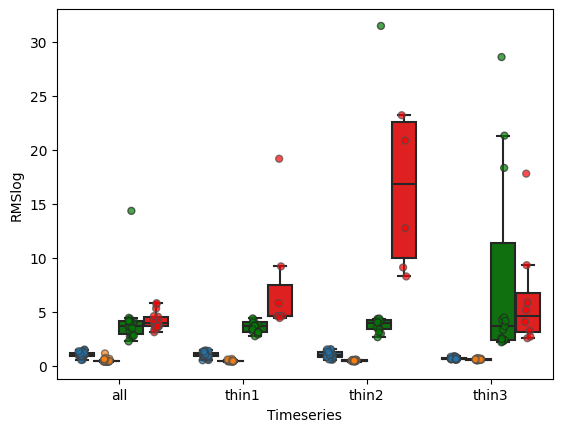

In [31]:
# # ====================================================== Plotting code
# fig, ax = plt.subplots(1, 1)
# box_and_scatter_plot(
#     fwsim_metric_thinning_df, 
#     ax, 
#     x='Timeseries', y='RMSlog', 
#     method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
#     method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
#     title=None, 
#     render_pvalues=False
# )

# 9. All plots together

requires that the above cells have already ran, so that the following dataframes are pre-computed:

`interaction_metric_thinning_df`

`growth_metric_thinning_df`

`coclust_metric_thinning_df`

`pert_metric_thinning_df`

(todo) fwsim df

## Helpers

In [31]:
import string
def add_figure_labels(fig, axes, labels=None, dx: float = -25/72, dy: float = -3/72):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise ValueError("Number of labels do not match number of axes.")
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        lbl = labels[n]
        _ax.text(
            0., 1.05, lbl, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )

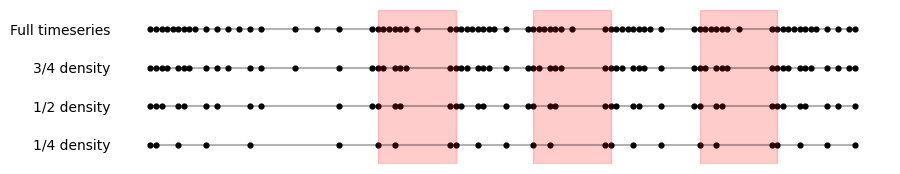

In [75]:
import matplotlib.pyplot as plt

def plot_timeseries_densities(ax):
    times_dict = {
        'Full timeseries': base_study['2'].times,
        '3/4 density': md2.Study.load("../datasets/semisynthetic2/trajectory_replicate_0/perts_3/data_replicate_0/mice_4/timepoints_thin1/mdsine2/synthetic.pkl")['SYNTH_SUBJ_0'].times,
        '1/2 density': md2.Study.load("../datasets/semisynthetic2/trajectory_replicate_0/perts_3/data_replicate_0/mice_4/timepoints_thin2/mdsine2/synthetic.pkl")['SYNTH_SUBJ_0'].times,
        # '1/2 density (alt)': md2.Study.load("../datasets/semisynthetic2/trajectory_replicate_0/perts_3/data_replicate_0/mice_4/timepoints_thin2_alt/mdsine2/synthetic.pkl")['SYNTH_SUBJ_0'].times,
        '1/4 density': md2.Study.load("../datasets/semisynthetic2/trajectory_replicate_0/perts_3/data_replicate_0/mice_4/timepoints_thin3/mdsine2/synthetic.pkl")['SYNTH_SUBJ_0'].times,
    }

    ylabel = []
    yvals = []
    for _i, (t_label, times) in enumerate(times_dict.items()):
        ylabel.append(t_label)
        y = len(times_dict) - _i
        yvals.append(y)
        ax.scatter(x=times, y=len(times) * [y], color='black', s=12)
        ax.plot(times, len(times) * [y], color='black', alpha=0.3)
    
    
    # thinned_2 = rarify_uniform(8/9, thinned_1)  # target ratio is 2/3 = (3/4) * (8/9)
    # axes[2].scatter(x=thinned_2, y=len(thinned_2) * [0.0])
    # thinned_3 = rarify_uniform(3/4, thinned_2)  # target ratio is 1/2 = (2/3) * (3/4)
    # axes[3].scatter(x=thinned_3, y=len(thinned_3) * [0.0])
    
    for pert in base_study.perturbations:
        p_start = pert.starts['2']
        p_end = pert.ends['2']
        ax.axvspan(p_start, p_end, alpha=0.2, color='red')
    ax.set_ylim(np.min(yvals) - 0.5, np.max(yvals) + 0.5)
    ax.set_yticks(yvals)
    ax.set_yticklabels(ylabel)
    ax.set_xticks([])

    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    ax.tick_params(axis='y', length=0)


fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_timeseries_densities(ax)
plt.savefig("plots/semisynthetic_timeseries.pdf", bbox_inches='tight')

(<Axes:label='inset_axes'>, <Axes:label='inset_axes'>)

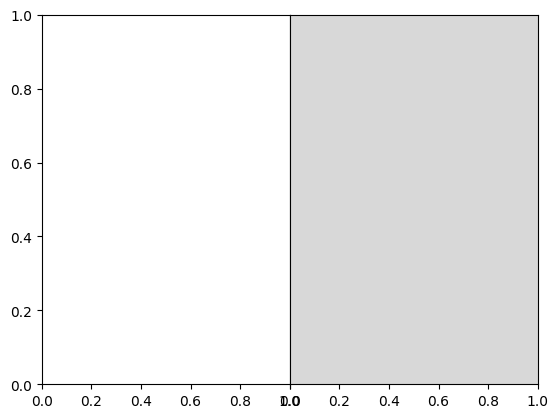

In [33]:
import matplotlib.patches


def split_ax(ax, x_lbl=0.06, y_lbl=0.96):
    """
    From an axis, create two smaller axes embedded side-by-side.
    """
    axin1 = ax.inset_axes([0.0, 0.0, 0.5, 1.0])
    axin2 = ax.inset_axes([0.5, 0.0, 0.5, 1.0])
    axin2.set_yticks([])
    ax.set_axis_off()

    rect = matplotlib.patches.Rectangle(
        (0, 0),            # Bottom-left corner of the rectangle
        1,                # Width of the rectangle
        1,                # Height of the rectangle
        facecolor="grey",   # Grey color
        alpha=0.3,          # 50% transparency
        transform=axin2.transAxes, # Use axes coordinates
        zorder=-1           # Ensure rectangle is behind other plot elements
    )
    axin2.add_patch(rect)

    # axin1.plot(x_lbl, y_lbl, 'o', color='black', fillstyle='full', markersize=15, transform=axin1.transAxes)
    # axin1.text(x_lbl, y_lbl, '1', transform=axin1.transAxes, ha='center', va='center', fontsize=12, zorder=3, color='white', weight="bold")

    # axin2.plot(x_lbl, y_lbl, 'o', color='black', fillstyle='full', markersize=15, transform=axin2.transAxes)
    # axin2.text(x_lbl, y_lbl, '2', transform=axin2.transAxes, ha='center', va='center', fontsize=12, zorder=3, color='white', weight="bold")
    return axin1, axin2


fig, ax = plt.subplots(1, 1)
split_ax(ax)

## Version 2.0

Evaluating p-value for: x=TimeseriesLabel, y=AUROC
Evaluating p-value for: x=TimeseriesLabel, y=AUROC
Evaluating p-value for: x=TimeseriesLabel, y=Spearman
Evaluating p-value for: x=TimeseriesLabel, y=Spearman


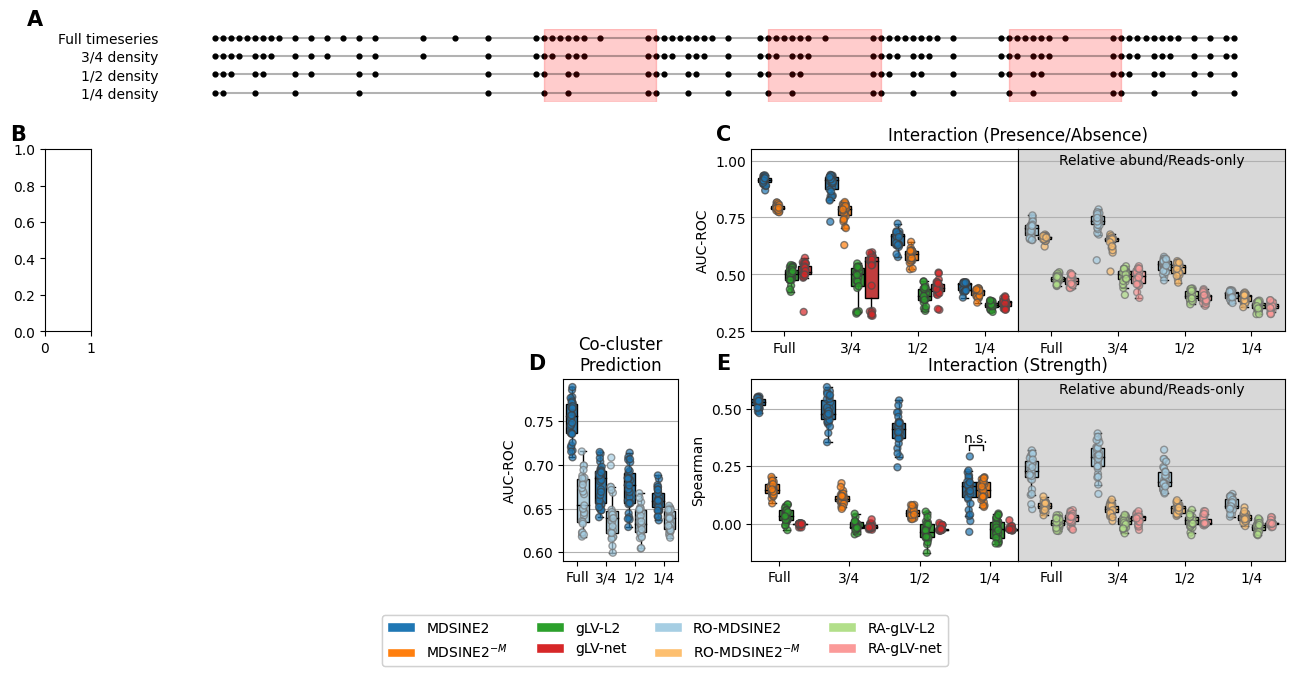

In [76]:
import itertools

width = 16
height = 8
show_points = True

n_rows = 4
n_cols = 7
_counter = itertools.count(start=0, step=1)
def empty_ax() -> str:
    return '?_{}'.format(next(_counter))

fig, axes = plt.subplot_mosaic(
    mosaic=[
        [ empty_ax(),   'Timeseries',  'Timeseries',  'Timeseries',     'Timeseries',            'Timeseries'       ],
        [ 'Network',    empty_ax(),    empty_ax(),    empty_ax(),        'InteractionAUROC',     'InteractionAUROC' ],
        [ empty_ax(),   empty_ax(),    empty_ax(),    'ClusterAUROC',    'InteractionStrength',  'InteractionStrength'        ],
        [ 'Legend',     'Legend',      'Legend',      'Legend',          'Legend',                'Legend']
    ],
    gridspec_kw=dict(
        hspace=0.4,
        wspace=0.5,
        height_ratios=[0.4, 1, 1, 0.2],
        width_ratios=[0.2, 0.6, 0.5, 0.5, 1, 1],
    ),
    figsize=(width, height),
)
for key, ax in axes.items():
    if key.startswith('?'):
        ax.set_axis_off()

plot_timeseries_densities(axes['Timeseries'])


method_order_all = [
    'MDSINE2',
    'MDSINE2_nomodule',
    'glv_ridge', 
    'glv_elastic_net', 
    'RA-MDSINE2',
    'RA-MDSINE2_nomodule',
    'glv-ra_ridge',
    'glv-ra_elastic_net', 
]
method_order_base = [
    'MDSINE2',
    'MDSINE2_nomodule',
    'glv_ridge', 
    'glv_elastic_net', 
]
method_order_ra = [
    'RA-MDSINE2',
    'RA-MDSINE2_nomodule',
    'glv-ra_ridge',
    'glv-ra_elastic_net',
]
palette = sb.color_palette("tab10", n_colors=10)
paired_palette = sb.color_palette("Paired")
method_colors = {
    'MDSINE2': palette[0], 
    'MDSINE2_nomodule': palette[1], 
    'RA-MDSINE2': paired_palette[0], 
    'RA-MDSINE2_nomodule': paired_palette[6], 
    'glv_ridge': palette[2],
    'glv_elastic_net': palette[3],
    'glv-ra_elastic_net': paired_palette[4], 
    'glv-ra_ridge': paired_palette[2]
}

legend_labels = {
    'MDSINE2_nomodule': r'MDSINE$2^{-M}$', 
    'MDSINE2': 'MDSINE2', 
    'RA-MDSINE2_nomodule': r'RO-MDSINE$2^{-M}$', 
    'RA-MDSINE2': r'RO-MDSINE2', 
    'glv_ridge': 'gLV-L2',
    'glv_elastic_net': 'gLV-net',
    'glv-ra_elastic_net': 'RA-gLV-net', 
    'glv-ra_ridge': 'RA-gLV-L2',
}

""" initialize labels and data structures """
pvalue_tables = {}
timeseries_label_order = {
    'all': 0, 'thin1': 1, 'thin2': 2, 'thin3': 3
}
timeseries_label = {
    'all': 'Full',
    'thin1': '3/4',
    'thin2': '1/2',
    'thin3': '1/4',
}

""" Interactions """
ax = axes['InteractionAUROC']
ax.set_title("Interaction (Presence/Absence)")


ax1, ax2 = split_ax(ax, x_lbl=0.95, y_lbl=0.93)
interaction_auroc_pvalues_abs = box_and_scatter_plot(
    interaction_metric_thinning_df.assign(
        TimeseriesLabelOrder=interaction_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=interaction_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax1, 
    x='TimeseriesLabel', y='AUROC', 
    method_order=method_order_base, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False,
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([0.25, 0.5, 0.75, 1.0])
y1, y2 = ax1.get_ylim()
ax1.set_ylim(y1, y2 + 0.05)
ax1.yaxis.set_tick_params(length=0)
pvalue_tables['interaction_auroc_abs'] = interaction_auroc_pvalues_abs


interaction_auroc_pvalues_rel = box_and_scatter_plot(
    interaction_metric_thinning_df.assign(
        TimeseriesLabelOrder=interaction_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=interaction_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax2, 
    x='TimeseriesLabel', y='AUROC',
    method_order=method_order_ra, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='RA-MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.sharey(ax1)
ax2.yaxis.set_tick_params(labelleft=False, length=0)
ax2.text(x=0.5, y=0.94, s="Relative abund/Reads-only", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax1.set_ylabel("AUC-ROC")
pvalue_tables['interaction_auroc_rel'] = interaction_auroc_pvalues_rel


ax = axes['InteractionStrength']
ax.set_title("Interaction (Strength)")

ax1, ax2 = split_ax(ax, x_lbl=0.95, y_lbl=0.93)
interaction_str_pvalues_abs = box_and_scatter_plot(
    interaction_metric_thinning_df.assign(
        TimeseriesLabelOrder=interaction_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=interaction_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax1, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_base, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([0., 0.25, 0.5])

pvalue_tables['interaction_str_abs'] = interaction_str_pvalues_abs


# box_and_scatter_plot(interaction_metric_df_v2, ax, 'InteractionDiffRaw_All', method_order=method_order, method_colors=method_colors, title="Interaction RMSE (All)")
interaction_str_pvalues_rel = box_and_scatter_plot(
    interaction_metric_thinning_df.assign(
        TimeseriesLabelOrder=interaction_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=interaction_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax2, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_ra, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='RA-MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points, debug_pvals=False
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.sharey(ax1)
ax2.yaxis.set_tick_params(labelleft=False, length=0)
ax2.text(x=0.5, y=0.94, s="Relative abund/Reads-only", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax1.set_ylabel("Spearman")
pvalue_tables['interaction_str_rel'] = interaction_str_pvalues_rel



""" Clustering """
ax = axes['ClusterAUROC']
box_and_scatter_plot(
    coclust_metric_thinning_df.assign(
        TimeseriesLabelOrder=coclust_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=coclust_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'),
    ax, 
    x='TimeseriesLabel', 
    y='CoclustAUROC', 
    method_order=['MDSINE2', 'RA-MDSINE2'], 
    method_colors=method_colors, 
    title=None, render_pvalues=False,
    show_points=show_points
) 
ax.set_title("Co-cluster\nPrediction")
ax.set_ylabel("AUC-ROC")
ax.set_xlabel("")


""" Figure labels """
add_figure_labels(fig, [axes['Timeseries']], 'A', dx=-1.37)
add_figure_labels(fig, [axes['Network']], ['B'])
add_figure_labels(fig, [axes['InteractionAUROC']], ['C'])
add_figure_labels(fig, [axes['ClusterAUROC']], ['D'])
add_figure_labels(fig, [axes['InteractionStrength']], ['E'])

""" legend """
legend_ax = axes['Legend']
legend_ax.axis('off')
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=method_colors[m], edgecolor='w', label=legend_labels[m])
    for m in method_order_all
]
legend1 = legend_ax.legend(handles=legend_elements, loc='upper center', ncol=4)
legend_ax.add_artist(legend1)

plt.savefig("plots/semisynthetic2_plot_draft_MAIN.pdf", bbox_inches='tight')

In [83]:
base_id_cols = ['TrajReplicate', 'NumPerts', 'DataReplicate', 'NumMice', 'Timeseries', 'Method']

merged_data_df = interaction_metric_thinning_df[base_id_cols + ['AUROC', 'Spearman']].rename(columns={'AUROC': 'InteractionAUROC', 'Spearman': 'InteractionSpearman'}
).merge(
    coclust_metric_thinning_df[base_id_cols + ['CoclustAUROC']],
    on=base_id_cols, how='outer'
).merge(
    pert_metric_thinning_df[base_id_cols + ['AUROC', 'Spearman']].rename(columns={'AUROC': 'PerturbationAUROC', 'Spearman': 'PerturbationSpearman'}),
    on=base_id_cols, how='outer'
).merge(
    growth_metric_thinning_df[base_id_cols + ['Spearman']].rename(columns={'Spearman': 'GrowthSpearman'}),
    on=base_id_cols, how='outer'
)

merged_data_df = merged_data_df.loc[merged_data_df['Timeseries'].isin({'all', 'thin1', 'thin2', 'thin3'})]

table_dir = Path("tables/fig4_semisynthetic")
table_dir.mkdir(exist_ok=True, parents=True)
merged_data_df.to_csv(table_dir / "data.tsv", sep='\t', index=False)

In [82]:
import csv
interaction_auroc_pvalues_abs.to_csv(table_dir / "interaction_auroc_pvals_abs.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
interaction_auroc_pvalues_rel.to_csv(table_dir / "interaction_auroc_pvals_rel.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
interaction_str_pvalues_abs.to_csv(table_dir / "interaction_str_pvalues_abs.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
interaction_str_pvalues_rel.to_csv(table_dir / "interaction_str_pvalues_rel.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
pert_auroc_pvalues_abs.to_csv(table_dir / "pert_auroc_pvalues_abs.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
pert_auroc_pvalues_rel.to_csv(table_dir / "pert_auroc_pvalues_rel.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
pert_str_pvalues_abs.to_csv(table_dir / "pert_str_pvalues_abs.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
pert_str_pvalues_rel.to_csv(table_dir / "pert_str_pvalues_rel.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
growth_pvalues_abs.to_csv(table_dir / "growth_pvalues_abs.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)
growth_pvalues_rel.to_csv(table_dir / "growth_pvalues_rel.tsv", sep='\t', quoting=csv.QUOTE_ALL, index=False)

Evaluating p-value for: x=TimeseriesLabel, y=AUROC
Evaluating p-value for: x=TimeseriesLabel, y=AUROC
Evaluating p-value for: x=TimeseriesLabel, y=Spearman
Evaluating p-value for: x=TimeseriesLabel, y=Spearman
Evaluating p-value for: x=TimeseriesLabel, y=Spearman
Evaluating p-value for: x=TimeseriesLabel, y=Spearman


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


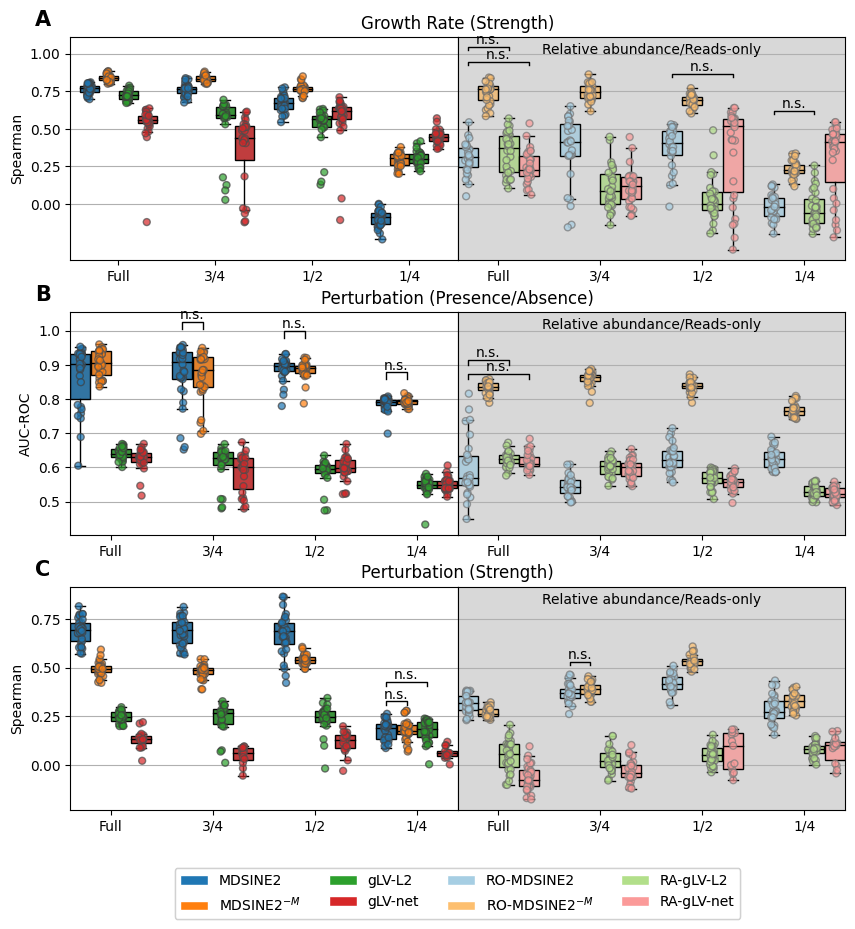

In [86]:
import itertools

width = 10
height = 11
show_points = True


fig, axes = plt.subplot_mosaic(
    mosaic=[
        ['Growth'],
        ['PertAUROC'],
        ['PertStrength'],
        ['Legend'],
    ],
    gridspec_kw=dict(
        hspace=0.3,
        wspace=0.15,
        height_ratios=[1, 1, 1, 0.1],
    ),
    figsize=(width, height),
)
method_order_base = [
    'MDSINE2',
    'MDSINE2_nomodule',
    'glv_ridge', 
    'glv_elastic_net', 
]
method_order_ra = [
    'RA-MDSINE2',
    'RA-MDSINE2_nomodule',
    'glv-ra_ridge',
    'glv-ra_elastic_net',
]
palette = sb.color_palette("tab10", n_colors=10)
paired_palette = sb.color_palette("Paired")
method_colors = {
    'MDSINE2': palette[0], 
    'MDSINE2_nomodule': palette[1], 
    'RA-MDSINE2': paired_palette[0], 
    'RA-MDSINE2_nomodule': paired_palette[6], 
    'glv_ridge': palette[2],
    'glv_elastic_net': palette[3],
    'glv-ra_elastic_net': paired_palette[4], 
    'glv-ra_ridge': paired_palette[2]
}

legend_labels = {
    'MDSINE2_nomodule': r'MDSINE$2^{-M}$', 
    'MDSINE2': 'MDSINE2', 
    'RA-MDSINE2_nomodule': r'RO-MDSINE$2^{-M}$', 
    'RA-MDSINE2': r'RO-MDSINE2', 
    'glv_ridge': 'gLV-L2',
    'glv_elastic_net': 'gLV-net',
    'glv-ra_elastic_net': 'RA-gLV-net', 
    'glv-ra_ridge': 'RA-gLV-L2',
}

""" pert AUROC """
ax = axes[f'PertAUROC']
ax.set_title("Perturbation (Presence/Absence)")

ax1, ax2 = split_ax(ax, x_lbl=0.97, y_lbl=0.93)
pert_auroc_pvalues_abs = box_and_scatter_plot(
    pert_metric_thinning_df.assign(
        TimeseriesLabelOrder=pert_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=pert_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax1, 
    x='TimeseriesLabel', 
    y='AUROC', 
    method_order=method_order_base, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='MDSINE2',
    pvalue_offset_factor=0.05, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax1.set_ylabel("")
ax1.set_xlabel("")

pert_auroc_pvalues_rel = box_and_scatter_plot(
    pert_metric_thinning_df.assign(
        TimeseriesLabelOrder=pert_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=pert_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax2, 
    x='TimeseriesLabel', 
    y='AUROC', 
    method_order=method_order_ra, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='RA-MDSINE2',
    pvalue_offset_factor=0.001, pvalue_dy=0.015, pvalue_overlap_gap=0.04,
    show_points=show_points
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.sharey(ax1)
ax2.yaxis.set_tick_params(labelleft=False, length=0)
ax2.text(x=0.5, y=0.94, s="Relative abundance/Reads-only", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax2.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax1.set_ylabel("AUC-ROC")


""" Pert Strength """
ax = axes[f'PertStrength']
ax.set_title("Perturbation (Strength)")

ax1, ax2 = split_ax(ax, x_lbl=0.97, y_lbl=0.93)
pert_str_pvalues_abs = box_and_scatter_plot(
    pert_metric_thinning_df.assign(
        TimeseriesLabelOrder=pert_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=pert_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax1, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_base, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([0., 0.25, 0.5, 0.75, 1.0])

pert_str_pvalues_rel = box_and_scatter_plot(
    pert_metric_thinning_df.assign(
        TimeseriesLabelOrder=pert_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=pert_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax2, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_ra, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='RA-MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.sharey(ax1)
ax2.yaxis.set_tick_params(labelleft=False, length=0)
ax2.text(x=0.5, y=0.94, s="Relative abundance/Reads-only", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax1.set_ylabel("Spearman")


""" Growth """
ax = axes[f'Growth']
ax.set_title("Growth Rate (Strength)")

ax1, ax2 = split_ax(ax, x_lbl=0.97, y_lbl=0.93)
growth_pvalues_abs = box_and_scatter_plot(
    growth_metric_thinning_df.assign(
        TimeseriesLabelOrder=growth_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=growth_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax1, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_base, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([0., 0.25, 0.5, 0.75, 1.0])

growth_pvalues_rel = box_and_scatter_plot(
    growth_metric_thinning_df.assign(
        TimeseriesLabelOrder=growth_metric_thinning_df['Timeseries'].map(timeseries_label_order),
        TimeseriesLabel=growth_metric_thinning_df['Timeseries'].map(timeseries_label),
    ).sort_values('TimeseriesLabelOrder'), 
    ax2, 
    x='TimeseriesLabel', 
    y='Spearman', 
    method_order=method_order_ra, 
    method_colors=method_colors, 
    title=None, render_pvalues=True, show_nonsig=True, show_sig=False, baseline_method='RA-MDSINE2',
    pvalue_offset_factor=0.1, pvalue_dy=0.02, pvalue_overlap_gap=0.1,
    show_points=show_points
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.sharey(ax1)
ax2.yaxis.set_tick_params(labelleft=False, length=0)
ax2.text(x=0.5, y=0.94, s="Relative abundance/Reads-only", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
ax1.set_ylabel("Spearman")

""" Figure labels """
add_figure_labels(fig, [axes['Growth']], ['A'])
add_figure_labels(fig, [axes['PertAUROC']], ['B'])
add_figure_labels(fig, [axes['PertStrength']], ['C'])

""" legend """
legend_ax = axes['Legend']
legend_ax.axis('off')
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=method_colors[m], edgecolor='w', label=legend_labels[m])
    for m in method_order_all
]
legend1 = legend_ax.legend(handles=legend_elements, loc='upper center', ncol=4)
legend_ax.add_artist(legend1)



# plt.savefig("plots/semisynthetic2_plot_draft_EXTRAS.pdf", bbox_inches='tight')
plt.savefig("plots/semisynthetic2_plot_draft_EXTRAS.eps", format='eps', bbox_inches='tight')

# Extra Figures (for peer review)

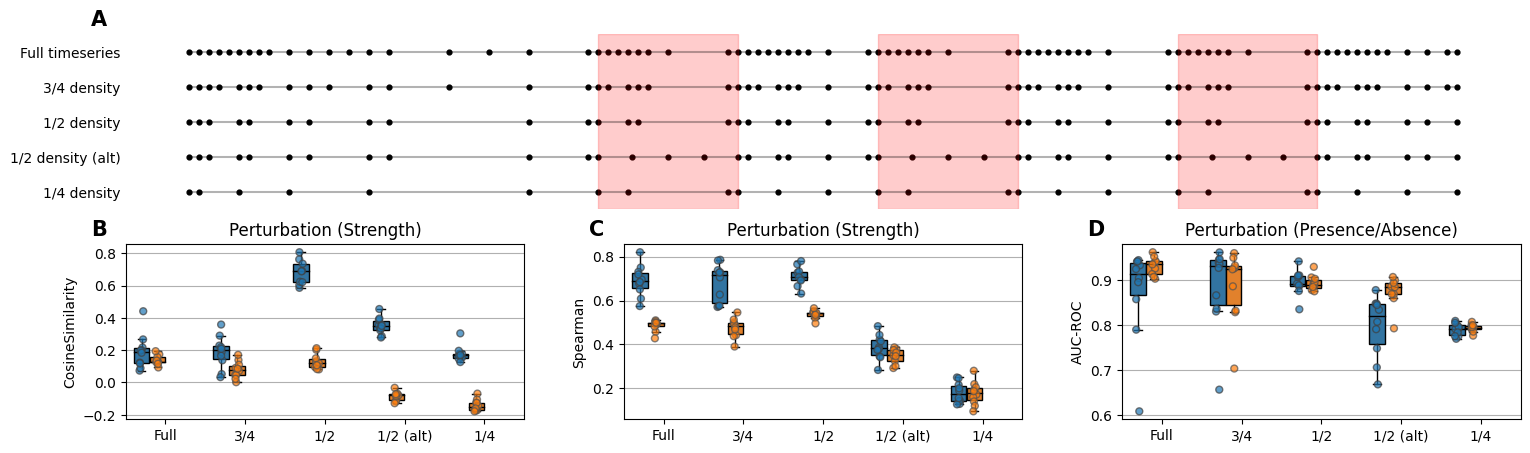

In [766]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'wspace': 0.25})
fig, axes = plt.subplot_mosaic(
    mosaic=[
        [ 'Timeseries', 'Timeseries', 'Timeseries' ],
        [ 0, 1, 2 ]
    ],
    gridspec_kw=dict(
        wspace=0.25,
    ),
    figsize=(18, 5),
)
plot_timeseries_densities(axes['Timeseries'])

box_and_scatter_plot(
    pert_metric_thinning_df.loc[
        pert_metric_thinning_df['Method'].str.contains('MDSINE2')
        & (pert_metric_thinning_df['DataReplicate'] == 0)
    ], 
    axes[0], 
    x='Timeseries', y='CosineSimilarity', 
    x_order=['all', 'thin1', 'thin2', 'thin2_alt', 'thin3'],
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
axes[0].set_title("Perturbation (Strength)")
box_and_scatter_plot(
    pert_metric_thinning_df.loc[
        pert_metric_thinning_df['Method'].str.contains('MDSINE2')
        & (pert_metric_thinning_df['DataReplicate'] == 0)
    ], 
    axes[1], 
    x='Timeseries', y='Spearman', 
    x_order=['all', 'thin1', 'thin2', 'thin2_alt', 'thin3'],
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
axes[1].set_title("Perturbation (Strength)")
box_and_scatter_plot(
    pert_metric_thinning_df.loc[
        pert_metric_thinning_df['Method'].str.contains('MDSINE2')
        & (pert_metric_thinning_df['DataReplicate'] == 0)
    ], 
    axes[2], 
    x='Timeseries', y='AUROC', 
    x_order=['all', 'thin1', 'thin2', 'thin2_alt', 'thin3'],
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
axes[2].set_title("Perturbation (Presence/Absence)")
axes[2].set_ylabel('AUC-ROC')

for axis in [axes[0], axes[1], axes[2]]:
    axis.set_xticklabels(['Full', '3/4', '1/2', '1/2 (alt)', '1/4'])
    axis.set_xlabel('')

add_figure_labels(fig, [axes['Timeseries'], axes[0], axes[1], axes[2]], ['A', 'B', 'C', 'D'])
plt.savefig('plots/pert_metrics_collection_v2-0_50.pdf', bbox_inches='tight')

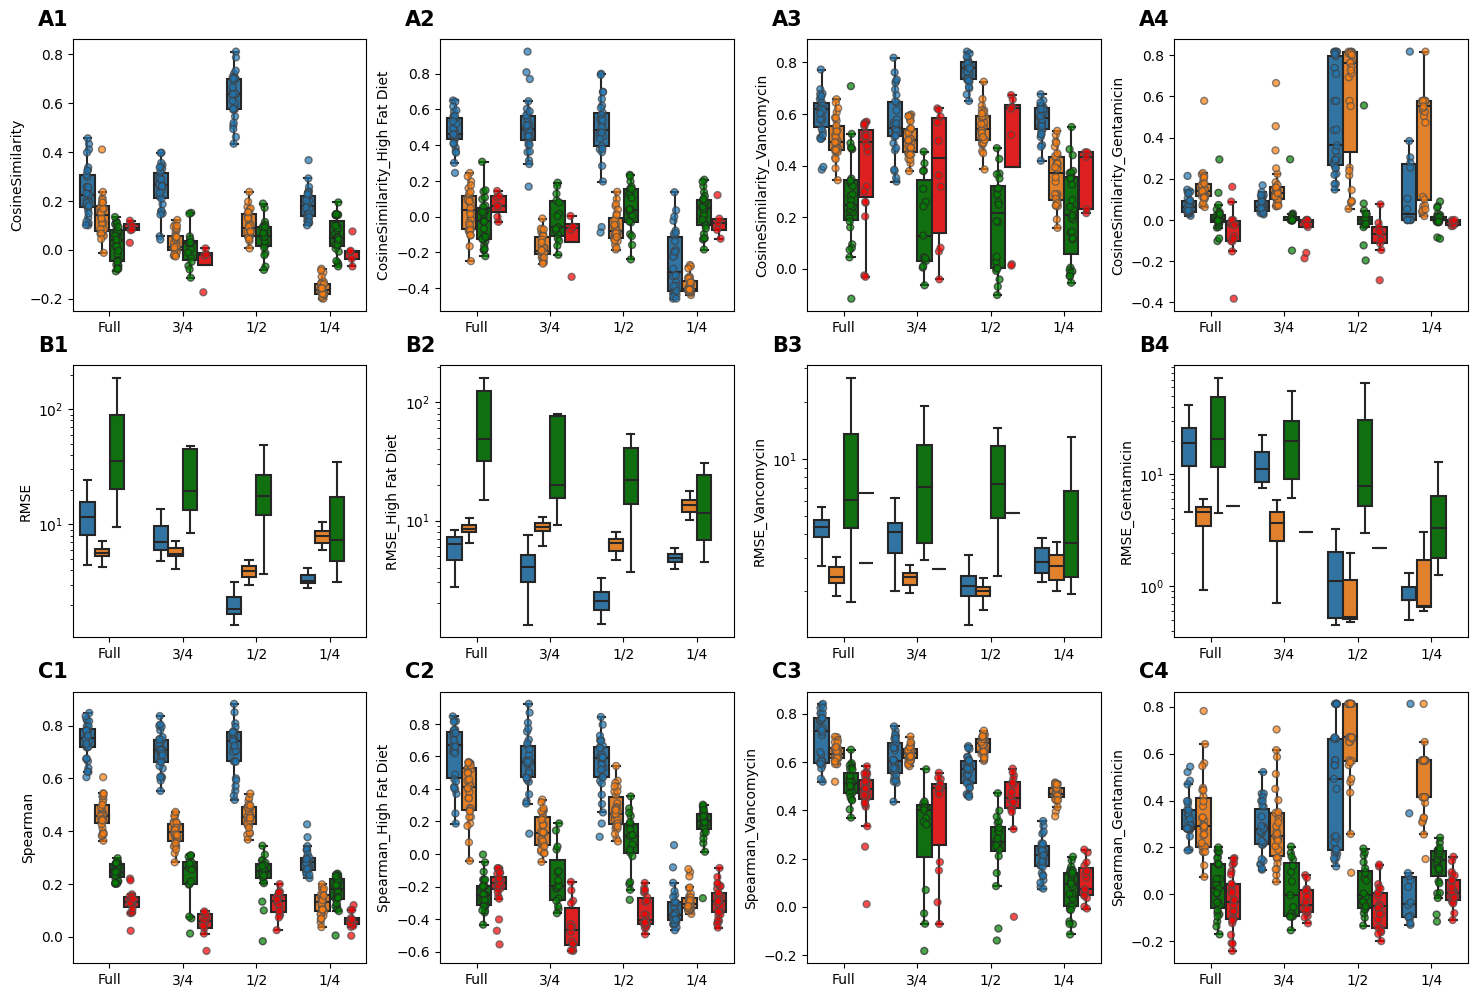

In [359]:
fig, ax = plt.subplots(3, 4, figsize=(18, 12), gridspec_kw={'wspace': 0.25})
# cosine sim
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,0], 
    x='Timeseries', y='CosineSimilarity', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,1], 
    x='Timeseries', y='CosineSimilarity_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,2], 
    x='Timeseries', y='CosineSimilarity_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,3], 
    x='Timeseries', y='CosineSimilarity_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

# rmse
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,0], 
    x='Timeseries', y='RMSE', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False, show_points=False
)
ax[1,0].set_yscale('log')
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,1], 
    x='Timeseries', y='RMSE_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False, show_points=False
)
ax[1,1].set_yscale('log')
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,2], 
    x='Timeseries', y='RMSE_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False, show_points=False
)
ax[1,2].set_yscale('log')
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,3], 
    x='Timeseries', y='RMSE_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False, show_points=False
)
ax[1,3].set_yscale('log')

# spearman
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[2,0], 
    x='Timeseries', y='Spearman', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[2,1], 
    x='Timeseries', y='Spearman_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[2,2], 
    x='Timeseries', y='Spearman_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[2,3], 
    x='Timeseries', y='Spearman_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

for axis in ax.flatten():
    axis.set_xticklabels(['Full', '3/4', '1/2', '1/4'])
    axis.set_xlabel('')

add_figure_labels(fig, ax.flatten(), ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4'])
# plt.savefig("plots/perts_metrics_collection.pdf", bbox_inches='tight')

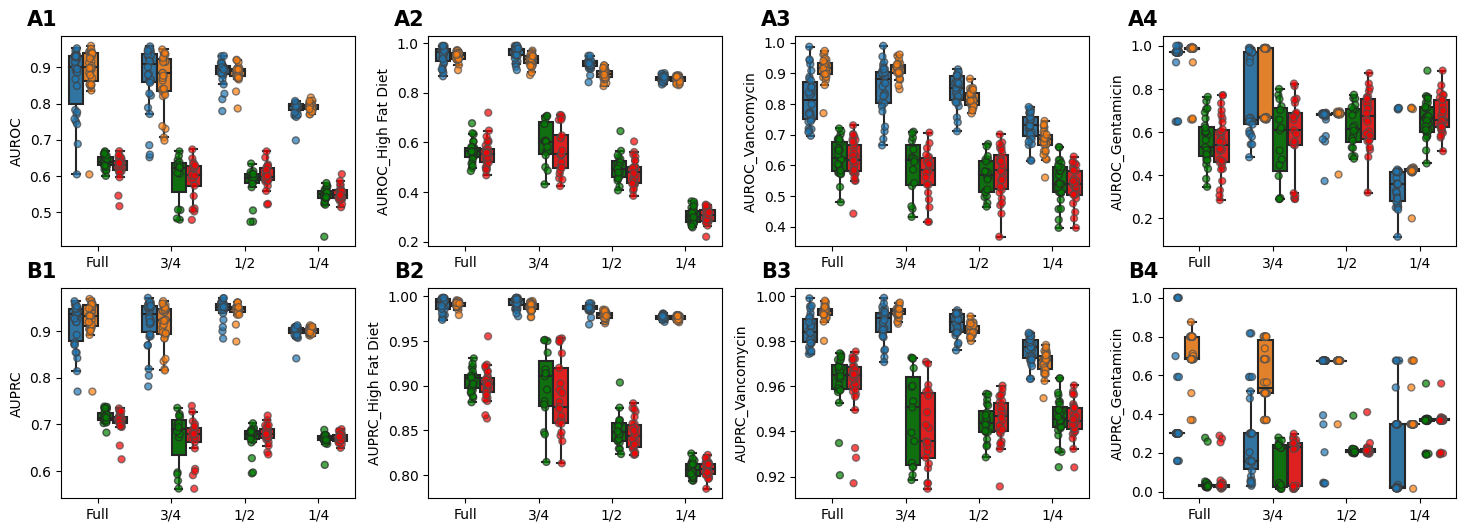

In [328]:
fig, ax = plt.subplots(2, 4, figsize=(18, 6), gridspec_kw={'wspace': 0.25})
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,0], 
    x='Timeseries', y='AUROC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,1], 
    x='Timeseries', y='AUROC_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,2], 
    x='Timeseries', y='AUROC_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[0,3], 
    x='Timeseries', y='AUROC_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

# PRC
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,0], 
    x='Timeseries', y='AUPRC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,1], 
    x='Timeseries', y='AUPRC_High Fat Diet', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,2], 
    x='Timeseries', y='AUPRC_Vancomycin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)
box_and_scatter_plot(
    pert_metric_thinning_df, 
    ax[1,3], 
    x='Timeseries', y='AUPRC_Gentamicin', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

for axis in ax.flatten():
    axis.set_xticklabels(['Full', '3/4', '1/2', '1/4'])
    axis.set_xlabel('')
add_figure_labels(fig, ax.flatten(), ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'])
plt.savefig("plots/perts_classification.pdf")

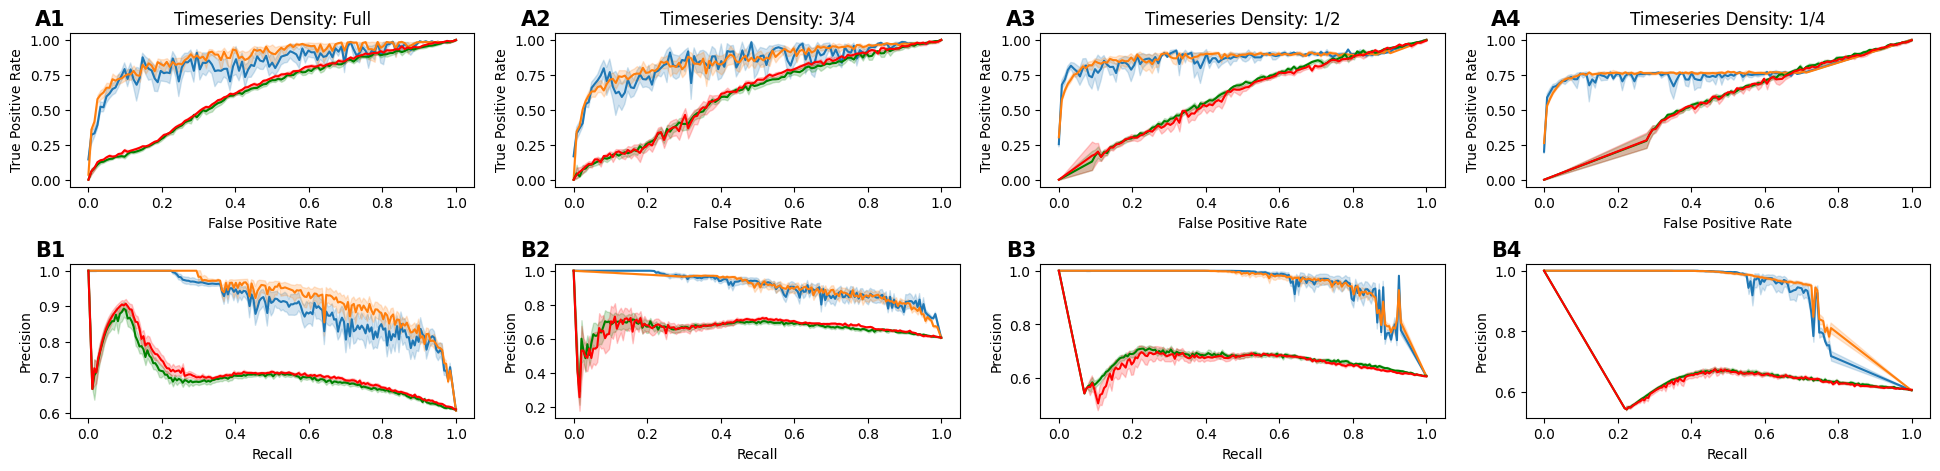

In [342]:
""" Precision-Recall curve and Receiver-operator curves for perturbation predictions """

method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net']
method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}

fig, axes = plt.subplots(2, 4, figsize=(24, 5), gridspec_kw={'hspace': 0.5})

ax_row = axes[1]
plot_curve_family([curve['PRC'] for curve in perts_mcmc_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in perts_mcmc_nomodule_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in perts_elastic_net_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in perts_ridge_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('Recall')
ax_row[0].set_ylabel('Precision')
# ax_row[0].set_title('All Perturbations')

plot_curve_family([curve['PRC'] for curve in perts_mcmc_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in perts_mcmc_nomodule_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in perts_elastic_net_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in perts_ridge_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('Recall')
ax_row[1].set_ylabel('Precision')
# ax_row[1].set_title('High Fat Diet')

plot_curve_family([curve['PRC'] for curve in perts_mcmc_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in perts_mcmc_nomodule_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in perts_elastic_net_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in perts_ridge_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('Recall')
ax_row[2].set_ylabel('Precision')
# ax_row[2].set_title('Vancomycin')

plot_curve_family([curve['PRC'] for curve in perts_mcmc_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in perts_mcmc_nomodule_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in perts_elastic_net_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in perts_ridge_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('Recall')
ax_row[3].set_ylabel('Precision')
# ax_row[3].set_title('Gentamicin')


ax_row = axes[0]
plot_curve_family([curve['ROC'] for curve in perts_mcmc_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in perts_mcmc_nomodule_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in perts_elastic_net_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in perts_ridge_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('False Positive Rate')
ax_row[0].set_ylabel('True Positive Rate')
ax_row[0].set_title('Timeseries Density: Full')

plot_curve_family([curve['ROC'] for curve in perts_mcmc_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in perts_mcmc_nomodule_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in perts_elastic_net_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in perts_ridge_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('False Positive Rate')
ax_row[1].set_ylabel('True Positive Rate')
ax_row[1].set_title('Timeseries Density: 3/4')

plot_curve_family([curve['ROC'] for curve in perts_mcmc_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in perts_mcmc_nomodule_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in perts_elastic_net_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in perts_ridge_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('False Positive Rate')
ax_row[2].set_ylabel('True Positive Rate')
ax_row[2].set_title('Timeseries Density: 1/2')

plot_curve_family([curve['ROC'] for curve in perts_mcmc_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in perts_mcmc_nomodule_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in perts_elastic_net_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in perts_ridge_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('False Positive Rate')
ax_row[3].set_ylabel('True Positive Rate')
ax_row[3].set_title('Timeseries Density: 1/4')


add_figure_labels(fig, axes.flatten(), ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'])
plt.savefig("plots/perts_classification_curves.pdf", bbox_inches='tight')

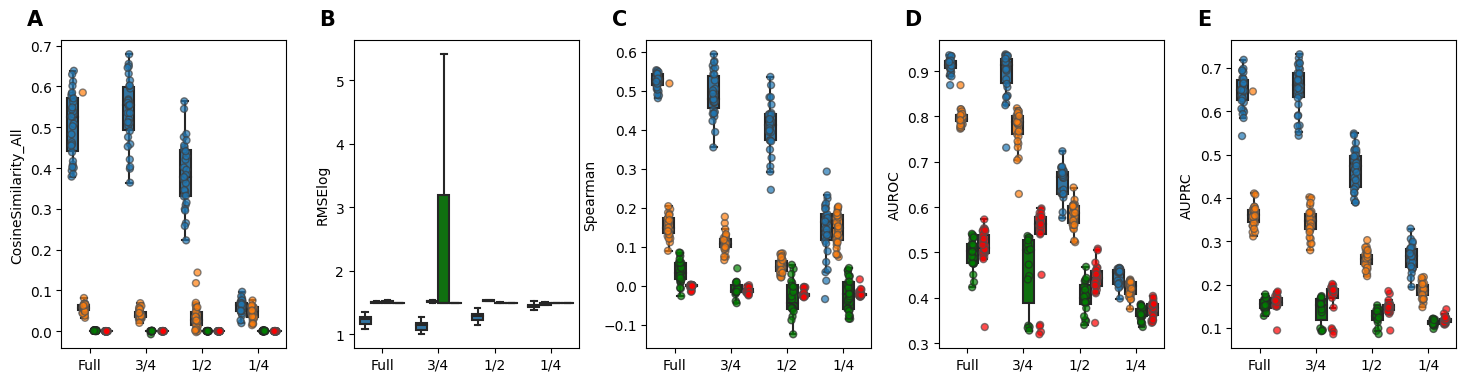

In [360]:
""" Interaction metric - RMSE, AUPRC, Spearman """

# ====================================================== Plotting code
fig, axes = plt.subplots(1, 5, figsize=(18, 4), gridspec_kw={'wspace': 0.3})

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    axes[0],
    x='Timeseries',
    y='CosineSimilarity_All', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    axes[1], 
    x='Timeseries',
    y='RMSElog', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False, show_points=False
)

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    axes[2],
    x='Timeseries',
    y='Spearman', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    axes[3],
    x='Timeseries',
    y='AUROC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

box_and_scatter_plot(
    interaction_metric_thinning_df, 
    axes[4],
    x='Timeseries',
    y='AUPRC', 
    method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net'], 
    method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}, 
    title=None, 
    render_pvalues=False
)

for ax in axes.flatten():
    ax.set_xticklabels(['Full', '3/4', '1/2', '1/4'])
    ax.set_xlabel('')


add_figure_labels(fig, axes.flatten(), ['A', 'B', 'C', 'D', 'E'])
plt.savefig("plots/interactions_extra.pdf", bbox_inches='tight')

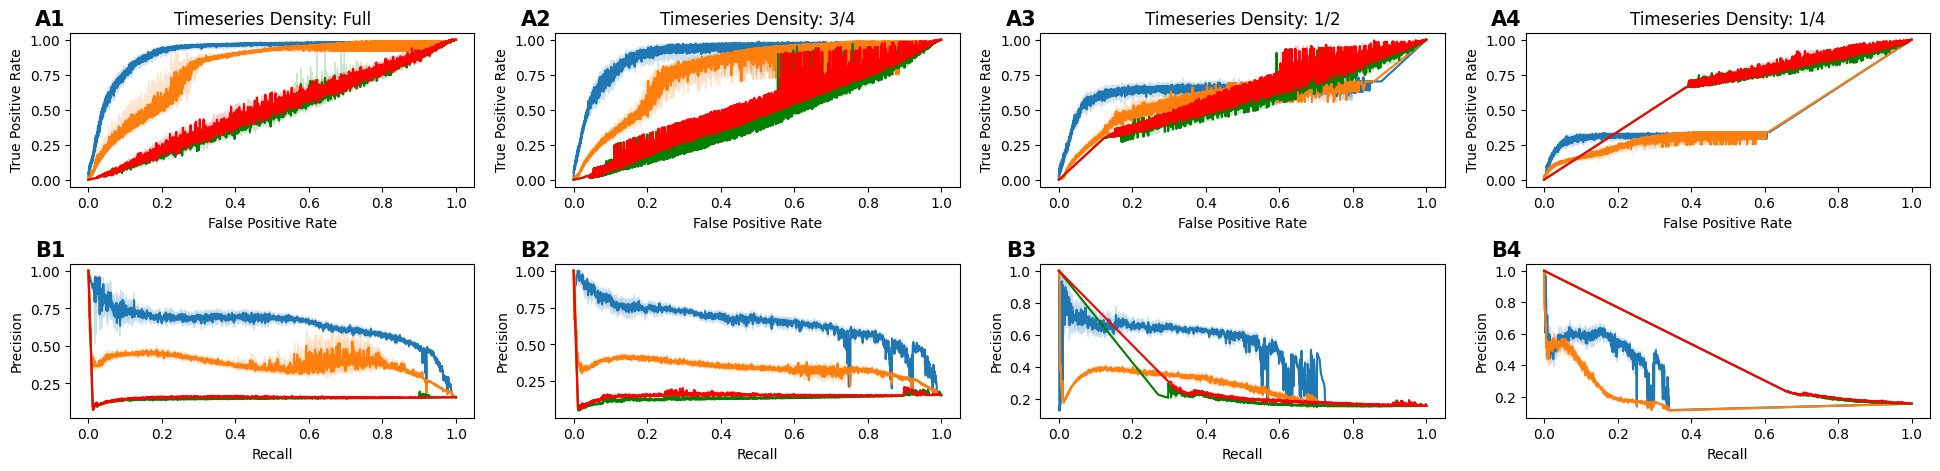

In [355]:
""" Precision-Recall curve and Receiver-operator curves for interaction topology predictions """

method_order=['MDSINE2', 'MDSINE2_nomodule', 'glv_ridge', 'glv_elastic_net']
method_colors={'MDSINE2': 'tab:blue', 'MDSINE2_nomodule': 'tab:orange', 'glv_ridge': 'green', 'glv_elastic_net': 'red'}

fig, axes = plt.subplots(2, 4, figsize=(24, 5), gridspec_kw={'hspace': 0.5})

ax_row = axes[1]
plot_curve_family([curve['PRC'] for curve in interactions_mcmc_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in interactions_mcmc_nomodule_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in interactions_elastic_net_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in interactions_ridge_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('Recall')
ax_row[0].set_ylabel('Precision')
# ax_row[0].set_title('All Perturbations')

plot_curve_family([curve['PRC'] for curve in interactions_mcmc_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in interactions_mcmc_nomodule_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in interactions_elastic_net_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in interactions_ridge_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('Recall')
ax_row[1].set_ylabel('Precision')
# ax_row[1].set_title('High Fat Diet')

plot_curve_family([curve['PRC'] for curve in interactions_mcmc_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in interactions_mcmc_nomodule_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in interactions_elastic_net_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in interactions_ridge_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('Recall')
ax_row[2].set_ylabel('Precision')
# ax_row[2].set_title('Vancomycin')

plot_curve_family([curve['PRC'] for curve in interactions_mcmc_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['PRC'] for curve in interactions_mcmc_nomodule_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['PRC'] for curve in interactions_elastic_net_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['PRC'] for curve in interactions_ridge_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('Recall')
ax_row[3].set_ylabel('Precision')
# ax_row[3].set_title('Gentamicin')


ax_row = axes[0]
plot_curve_family([curve['ROC'] for curve in interactions_mcmc_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in interactions_mcmc_nomodule_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in interactions_elastic_net_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in interactions_ridge_regression_curves['all']], ax_row[0], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[0].set_xlabel('False Positive Rate')
ax_row[0].set_ylabel('True Positive Rate')
ax_row[0].set_title('Timeseries Density: Full')

plot_curve_family([curve['ROC'] for curve in interactions_mcmc_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in interactions_mcmc_nomodule_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in interactions_elastic_net_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in interactions_ridge_regression_curves['thin1']], ax_row[1], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[1].set_xlabel('False Positive Rate')
ax_row[1].set_ylabel('True Positive Rate')
ax_row[1].set_title('Timeseries Density: 3/4')

plot_curve_family([curve['ROC'] for curve in interactions_mcmc_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in interactions_mcmc_nomodule_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in interactions_elastic_net_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in interactions_ridge_regression_curves['thin2']], ax_row[2], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[2].set_xlabel('False Positive Rate')
ax_row[2].set_ylabel('True Positive Rate')
ax_row[2].set_title('Timeseries Density: 1/2')

plot_curve_family([curve['ROC'] for curve in interactions_mcmc_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2']})
plot_curve_family([curve['ROC'] for curve in interactions_mcmc_nomodule_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['MDSINE2_nomodule']})
plot_curve_family([curve['ROC'] for curve in interactions_elastic_net_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_ridge']})
plot_curve_family([curve['ROC'] for curve in interactions_ridge_regression_curves['thin3']], ax_row[3], lineplot_kwargs={'color': method_colors['glv_elastic_net']})
ax_row[3].set_xlabel('False Positive Rate')
ax_row[3].set_ylabel('True Positive Rate')
ax_row[3].set_title('Timeseries Density: 1/4')


add_figure_labels(fig, axes.flatten(), ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'])
plt.savefig("plots/interactions_classification_curves.pdf", bbox_inches='tight')

# 10. Ground truth

In [259]:
def coclust_to_clustering(coclust: np.ndarray, full_taxa) -> np.ndarray:
    indices = set(range(coclust.shape[0]))

    clustering = np.zeros(coclust.shape[0], dtype=int)
    current_clust_id = 0
    while len(indices) > 0:
        _i = indices.pop()
        targets, = np.where(coclust[_i, :])
        for j in targets:
            clustering[j] = current_clust_id
            if j != _i:
                indices.remove(j)
        current_clust_id += 1

    # now, take the subset of taxa after filtering.
    return clustering

In [269]:
clustering = coclust_to_clustering(truth_coclust, base_study.taxa)
num_clusters = int(np.max(clustering)) + 1
for clust_idx in range(num_clusters):
    clust_sz = np.sum(clustering == clust_idx)
    print(f"Module {clust_idx + 1}: size = {clust_sz} taxa")


# truth_glv.interactions
import itertools
for clust_i, clust_j in itertools.product(range(num_clusters), range(num_clusters)):
    if clust_i == clust_j:
        continue
    _i_taxa_rep = np.where(clustering == clust_i)[0][0]
    _j_taxa_rep = np.where(clustering == clust_j)[0][0]
    interaction = truth_glv.interactions[_i_taxa_rep][_j_taxa_rep] ## interaction of module J on module I
    if interaction != 0.0:
        print("Module [{}] <-- [{}] (strength = {})".format(
            clust_i + 1,
            clust_j + 1,
            interaction
        ))

Module 1: size = 33 taxa
Module 2: size = 2 taxa
Module 3: size = 7 taxa
Module 4: size = 41 taxa
Module 5: size = 4 taxa
Module 6: size = 3 taxa
Module 7: size = 6 taxa
Module 8: size = 5 taxa
Module 9: size = 19 taxa
Module 10: size = 4 taxa
Module 11: size = 12 taxa
Module 12: size = 1 taxa
Module 13: size = 3 taxa
Module 14: size = 1 taxa
Module [1] <-- [5] (strength = -1.3440896511346819e-10)
Module [1] <-- [6] (strength = -4.866607414281234e-10)
Module [1] <-- [7] (strength = 9.550936390999263e-10)
Module [1] <-- [8] (strength = 4.0410747805368647e-10)
Module [1] <-- [9] (strength = 3.279596998428633e-10)
Module [1] <-- [11] (strength = -1.9573047756587444e-09)
Module [1] <-- [12] (strength = 4.0410747805368647e-10)
Module [1] <-- [14] (strength = -1.9573047756587444e-09)
Module [2] <-- [5] (strength = -6.129896570616284e-10)
Module [2] <-- [6] (strength = -1.4713998887826466e-09)
Module [2] <-- [7] (strength = 2.8166593381357248e-09)
Module [2] <-- [9] (strength = 1.444124172355